In [1]:
import numpy as np
import os, random
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import lightgbm as lgb
from tensorflow.keras import layers, callbacks, Model
from sklearn.model_selection import TimeSeriesSplit
from feature_engineering import engineer_features
from data_loader import load_all_data
from sentiment import add_vader_sentiment, aggregate_daily_sentiment
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime, timedelta


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
class RiskManager:
    """
    Comprehensive risk management system to prevent catastrophic drawdowns
    """
    
    def __init__(self, max_position_risk=0.02, max_portfolio_heat=0.10, 
                 max_drawdown=0.15, stop_loss_pct=0.05, circuit_breaker_dd=0.10):
        self.max_position_risk = max_position_risk  # Maximum 2% risk per trade
        self.max_portfolio_heat = max_portfolio_heat  # Maximum 10% portfolio risk
        self.max_drawdown = max_drawdown  # Maximum 15% drawdown before halting
        self.stop_loss_pct = stop_loss_pct  # 5% stop loss
        self.circuit_breaker_dd = circuit_breaker_dd  # 10% circuit breaker
        
        # Tracking variables
        self.current_portfolio_heat = 0.0
        self.peak_capital = 0.0
        self.current_drawdown = 0.0
        self.trading_halted = False
        self.consecutive_losses = 0
        self.max_consecutive_losses = 3
        
        # Position tracking
        self.open_positions = {}
        self.position_entry_prices = {}
        
    def reset(self, initial_capital):
        """Reset risk manager for new simulation"""
        self.peak_capital = initial_capital
        self.current_drawdown = 0.0
        self.trading_halted = False
        self.consecutive_losses = 0
        self.current_portfolio_heat = 0.0
        self.open_positions = {}
        self.position_entry_prices = {}
    
    def calculate_position_size(self, prediction_confidence, predicted_return, 
                              current_volatility, portfolio_value):
        """
        Calculate position size using Kelly criterion with strict risk limits
        """
        if self.trading_halted:
            return 0.0
        
        # Check if we can open new positions
        if self.current_portfolio_heat >= self.max_portfolio_heat:
            return 0.0
        
        # Kelly criterion with conservative adjustment
        win_prob = max(0.51, min(0.70, 0.5 + prediction_confidence * 0.3))
        avg_win = abs(predicted_return) * 0.7  # Conservative estimate
        avg_loss = abs(predicted_return) * 0.5  # Optimistic loss estimate
        
        if avg_loss == 0:
            kelly_fraction = 0.01
        else:
            kelly_fraction = (win_prob * avg_win - (1 - win_prob) * avg_loss) / avg_win
        
        # Apply strict position sizing rules
        kelly_fraction = max(0, min(kelly_fraction, self.max_position_risk))
        
        # Volatility adjustment
        vol_adjustment = min(1.0, 0.02 / max(current_volatility, 0.01))
        position_size = kelly_fraction * vol_adjustment
        
        # Additional risk adjustments
        if self.consecutive_losses >= 2:
            position_size *= 0.5  # Half size after 2 losses
        
        if self.current_drawdown > 0.05:
            position_size *= 0.7  # Reduce size during drawdown
        
        # Absolute maximum position size
        position_size = min(position_size, self.max_position_risk)
        
        return position_size
    
    def check_stop_loss(self, position_id, current_price, entry_price, position_type):
        """
        Check if position should be stopped out
        Returns: (should_close, stop_loss_triggered)
        """
        if position_id not in self.position_entry_prices:
            return False, False
        
        if position_type == 'long':
            price_change = (current_price - entry_price) / entry_price
        else:  # short
            price_change = (entry_price - current_price) / entry_price
        
        # Stop loss trigger
        if price_change <= -self.stop_loss_pct:
            return True, True
        
        return False, False
    
    def update_portfolio_heat(self, positions_dict):
        """
        Calculate current portfolio heat (total risk exposure)
        """
        total_heat = 0.0
        for position_id, position_size in positions_dict.items():
            total_heat += abs(position_size)
        
        self.current_portfolio_heat = total_heat
        return total_heat
    
    def check_circuit_breaker(self, current_capital):
        """
        Check if circuit breaker should be triggered
        """
        if current_capital > self.peak_capital:
            self.peak_capital = current_capital
        
        self.current_drawdown = (self.peak_capital - current_capital) / self.peak_capital
        
        if self.current_drawdown >= self.circuit_breaker_dd:
            self.trading_halted = True
            print(f"🚨 CIRCUIT BREAKER TRIGGERED - Drawdown: {self.current_drawdown:.2%}")
            return True
        
        return False
    
    def record_trade_outcome(self, profit_loss):
        """
        Record trade outcome for consecutive loss tracking
        """
        if profit_loss < 0:
            self.consecutive_losses += 1
        else:
            self.consecutive_losses = 0
        
        # Additional safety: halt after too many consecutive losses
        if self.consecutive_losses >= self.max_consecutive_losses:
            self.trading_halted = True
            print(f"🛑 Trading halted due to {self.consecutive_losses} consecutive losses")
    
    def can_trade(self):
        """
        Check if trading is allowed
        """
        return not self.trading_halted
    
    def get_risk_metrics(self):
        """
        Get current risk metrics
        """
        return {
            'portfolio_heat': self.current_portfolio_heat,
            'current_drawdown': self.current_drawdown,
            'consecutive_losses': self.consecutive_losses,
            'trading_halted': self.trading_halted,
            'risk_score': self._calculate_risk_score()
        }
    
    def _calculate_risk_score(self):
        """
        Calculate overall risk score (-1 to 1, where 1 is best)
        """
        # Start with neutral score
        score = 0.0
        
        # Portfolio heat component
        heat_score = 1.0 - (self.current_portfolio_heat / self.max_portfolio_heat)
        score += heat_score * 0.3
        
        # Drawdown component
        dd_score = 1.0 - (self.current_drawdown / self.max_drawdown)
        score += dd_score * 0.4
        
        # Consecutive losses component
        loss_score = 1.0 - (self.consecutive_losses / self.max_consecutive_losses)
        score += loss_score * 0.3
        
        # Penalty for trading halt
        if self.trading_halted:
            score = -1.0
        
        return max(-1.0, min(1.0, score))


class RegimeAwareBitcoinPredictor:
    """
    Bitcoin predictor with advanced regime detection and MANDATORY risk controls
    """
    
    def __init__(self, sequence_length=60, prediction_horizon=30, 
                 max_position_size=0.02, stop_loss_threshold=0.05,
                 bear_market_threshold=-0.15, prune_gb=True, ridge_alpha=2.0):
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.max_position_size = max_position_size  # Reduced to 2%
        self.stop_loss_threshold = stop_loss_threshold
        self.bear_market_threshold = bear_market_threshold
        self.prune_gb = prune_gb
        self.ridge_alpha = ridge_alpha
        
        # MANDATORY risk manager
        self.risk_manager = RiskManager(
            max_position_risk=max_position_size,
            max_portfolio_heat=0.08,  # Max 8% total portfolio risk
            max_drawdown=0.15,
            stop_loss_pct=stop_loss_threshold,
            circuit_breaker_dd=0.12  # 12% circuit breaker
        )
        
        # Model components
        self.models = {}
        self.regime_specific_models = {}
        self.meta_model = None
        self.scaler = None
        self.regime_scaler = None
        self.trained_feature_count = None
        self.expected_regime_columns = None
        
        # Regime tracking
        self.current_regime = 'neutral'
        self.regime_history = []
        self.bear_market_detected = False
        self.trend_momentum = 0.0
        
        # Performance tracking
        self.prediction_history = []
        self.consecutive_losses = 0
        
        # Volatility tracking for stress testing
        self.volatility_regime = 'normal'  # normal, high, extreme
        self.stress_multiplier = 1.0
        
        # Feature groups - simplified for better generalization
        self.feature_groups = {
            'price_volume': ['open', 'high', 'low', 'close', 'volume', 'high_close_ratio',
                             'low_close_ratio', 'open_close_ratio', 'volume_avg_ratio'],
            'returns': ['returns_1d', 'returns_3d', 'returns_7d', 'log_returns'],
            'momentum': ['momentum_5', 'momentum_10'],
            'technical': ['ma_5', 'price_ma_5_ratio', 'ma_20', 'price_ma_20_ratio',
                          'ema_12', 'ema_26', 'macd', 'rsi'],
            'volatility': ['bb_middle', 'bb_upper', 'bb_lower', 'bb_position', 'bb_width',
                           'volatility_10', 'volatility_20'],
            'sentiment': ['avg_vader_compound', 'article_count', 'vader_ma_3'],
            'funding': ['funding_rate'],
            'temporal': ['day_sin', 'day_cos']
        }
        
        # Add macroeconomic features
        self.macro_features = {
            'market_stress': ['vix_proxy', 'dollar_strength', 'risk_sentiment'],
            'cycles': ['market_cycle_phase', 'seasonality_factor']
        }
    
    def _ensure_numeric_series(self, series, column_name):
        """Safely convert series to numeric"""
        try:
            if pd.api.types.is_numeric_dtype(series):
                numeric_series = pd.to_numeric(series, errors='coerce')
            else:
                numeric_series = pd.to_numeric(series, errors='coerce')
            
            numeric_series = numeric_series.replace([np.inf, -np.inf], np.nan)
            
            if numeric_series.isna().all():
                return pd.Series([0.0] * len(series), index=series.index)
            
            median_val = numeric_series.median()
            if pd.isna(median_val):
                median_val = 0.0
            
            return numeric_series.fillna(median_val)
            
        except Exception as e:
            print(f"Warning: Could not convert {column_name} to numeric: {e}")
            return pd.Series([0.0] * len(series), index=series.index)
    
    def engineer_30day_target(self, df):
        """Engineer 30-day forward return target"""
        try:
            df = df.copy()
            if 'close' not in df.columns:
                print("Error: 'close' column not found")
                return df
            
            close = self._ensure_numeric_series(df['close'], 'close')
            
            # Calculate 30-day forward returns
            future_close = close.shift(-30)
            target_return = (future_close / close - 1).fillna(0)
            
            # Cap extreme values for stability
            target_return = np.clip(target_return, -0.5, 0.5)
            
            df['target_return_30d'] = target_return
            
            # Add market regime classification
            returns_7d = close.pct_change(7).fillna(0)
            volatility = returns_7d.rolling(30).std().fillna(0.15)
            
            # Simple regime classification
            regime = np.where(returns_7d > 0.05, 'bull',
                             np.where(returns_7d < -0.05, 'bear', 'neutral'))
            df['market_regime'] = regime
            
            return df
            
        except Exception as e:
            print(f"Error in target engineering: {e}")
            df['target_return_30d'] = 0.0
            df['market_regime'] = 'neutral'
            return df
    
    def prepare_features(self, df):
        """Prepare features for model training"""
        try:
            # Get all available features
            feature_columns = []
            
            # Add all feature groups
            for group_name, features in self.feature_groups.items():
                for feature in features:
                    if feature in df.columns:
                        feature_columns.append(feature)
            
            # Add macro features if available
            for group_name, features in self.macro_features.items():
                for feature in features:
                    if feature in df.columns:
                        feature_columns.append(feature)
            
            if len(feature_columns) == 0:
                print("Warning: No features found, using basic price features")
                if 'close' in df.columns:
                    feature_columns = ['close']
                else:
                    raise ValueError("No usable features found")
            
            # Extract features
            features_df = df[feature_columns].copy()
            
            # Ensure all features are numeric
            for col in features_df.columns:
                features_df[col] = self._ensure_numeric_series(features_df[col], col)
            
            # Scale features
            if self.scaler is None:
                self.scaler = RobustScaler()
                scaled_features = self.scaler.fit_transform(features_df.fillna(0))
            else:
                scaled_features = self.scaler.transform(features_df.fillna(0))
            
            return scaled_features, feature_columns
            
        except Exception as e:
            print(f"Error preparing features: {e}")
            # Return minimal fallback
            return np.zeros((len(df), 1)), ['fallback']
    
    def create_sequences(self, features, targets, regimes=None):
        """Create sequences for LSTM training"""
        try:
            if len(features) < self.sequence_length + 30:
                print(f"Insufficient data: need at least {self.sequence_length + 30}, got {len(features)}")
                return np.array([]), np.array([]), np.array([])
            
            X, y, regime_seq = [], [], []
            
            for i in range(self.sequence_length, len(features) - 30):
                if not np.isnan(targets[i]):
                    X.append(features[i-self.sequence_length:i])
                    y.append(targets[i])
                    if regimes is not None:
                        regime_seq.append(regimes[i])
            
            return np.array(X), np.array(y), np.array(regime_seq)
            
        except Exception as e:
            print(f"Error creating sequences: {e}")
            return np.array([]), np.array([]), np.array([])
    
    def detect_advanced_market_regimes(self, df):
        """Detect market regimes and bear market conditions"""
        try:
            if 'close' not in df.columns:
                self.current_regime = 'neutral'
                self.bear_market_detected = False
                return
            
            close = self._ensure_numeric_series(df['close'], 'close')
            
            # Calculate returns
            returns_7d = close.pct_change(7).fillna(0)
            returns_30d = close.pct_change(30).fillna(0)
            
            # Moving averages
            ma_50 = close.rolling(50).mean()
            ma_200 = close.rolling(200).mean()
            
            current_price = close.iloc[-1]
            current_ma_50 = ma_50.iloc[-1] if not pd.isna(ma_50.iloc[-1]) else current_price
            current_ma_200 = ma_200.iloc[-1] if not pd.isna(ma_200.iloc[-1]) else current_price
            
            # Bear market detection
            recent_return = returns_30d.iloc[-1]
            price_vs_ma200 = (current_price / current_ma_200 - 1) if current_ma_200 > 0 else 0
            
            self.bear_market_detected = (recent_return < self.bear_market_threshold or 
                                       price_vs_ma200 < -0.2)
            
            # Regime classification
            if self.bear_market_detected:
                self.current_regime = 'bear_volatile'
            elif current_price > current_ma_50 and current_ma_50 > current_ma_200:
                self.current_regime = 'bull_trending'
            elif current_price > current_ma_200:
                self.current_regime = 'bull_consolidating'
            else:
                self.current_regime = 'bear_declining'
                
        except Exception as e:
            print(f"Error detecting regimes: {e}")
            self.current_regime = 'neutral'
            self.bear_market_detected = False
    
    def calculate_trend_momentum(self, df):
        """Calculate trend momentum for position sizing"""
        try:
            if 'close' not in df.columns:
                self.trend_momentum = 0.0
                return
            
            close = self._ensure_numeric_series(df['close'], 'close')
            
            # Multiple timeframe momentum
            momentum_5 = close.pct_change(5).fillna(0)
            momentum_20 = close.pct_change(20).fillna(0)
            
            # Weighted momentum
            self.trend_momentum = (momentum_5.iloc[-1] * 0.3 + momentum_20.iloc[-1] * 0.7)
            self.trend_momentum = np.clip(self.trend_momentum, -0.2, 0.2)
            
        except Exception as e:
            print(f"Error calculating momentum: {e}")
            self.trend_momentum = 0.0

    def detect_volatility_regime(self, df):
        """Detect volatility regime for stress testing resilience"""
        try:
            if 'volatility_20' not in df.columns:
                self.volatility_regime = 'normal'
                self.stress_multiplier = 1.0
                return
            
            vol_20 = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
            
            # Calculate rolling volatility percentiles
            vol_window = min(252, len(vol_20))  # 1 year or available data
            if vol_window < 30:
                self.volatility_regime = 'normal'
                self.stress_multiplier = 1.0
                return
            
            vol_rolling = vol_20.rolling(vol_window)
            current_vol = vol_20.iloc[-1]
            
            # Calculate percentiles
            vol_75 = vol_rolling.quantile(0.75).iloc[-1]
            vol_90 = vol_rolling.quantile(0.90).iloc[-1]
            vol_95 = vol_rolling.quantile(0.95).iloc[-1]
            
            # Classify volatility regime
            if current_vol >= vol_95:
                self.volatility_regime = 'extreme'
                self.stress_multiplier = 0.3  # Extremely conservative
            elif current_vol >= vol_90:
                self.volatility_regime = 'high'
                self.stress_multiplier = 0.5  # Very conservative
            elif current_vol >= vol_75:
                self.volatility_regime = 'elevated'
                self.stress_multiplier = 0.7  # Conservative
            else:
                self.volatility_regime = 'normal'
                self.stress_multiplier = 1.0
            
            print(f"Volatility regime: {self.volatility_regime} (multiplier: {self.stress_multiplier})")
            
        except Exception as e:
            print(f"Error detecting volatility regime: {e}")
            self.volatility_regime = 'normal'
            self.stress_multiplier = 1.0
    
    def detect_regime_transitions(self, df):
        """Enhanced regime transition detection with early warning system"""
        try:
            transition_indicators = {}
            
            # 1. Moving average convergence/divergence
            if 'close' in df.columns:
                close = self._ensure_numeric_series(df['close'], 'close')
                
                # Multiple MA timeframes
                ma_10 = close.rolling(10).mean()
                ma_20 = close.rolling(20).mean()
                ma_50 = close.rolling(50).mean()
                
                # MA slope changes (trend direction shifts)
                ma_10_slope = ma_10.diff(5) / ma_10.shift(5)
                ma_20_slope = ma_20.diff(10) / ma_20.shift(10)
                
                transition_indicators['ma_slope_divergence'] = abs(ma_10_slope.iloc[-1] - ma_20_slope.iloc[-1]) > 0.05
                transition_indicators['ma_cross'] = (
                    (ma_10.iloc[-1] > ma_20.iloc[-1]) != (ma_10.iloc[-2] > ma_20.iloc[-2])
                )
            
            # 2. Volatility regime shifts
            if 'volatility_20' in df.columns:
                vol_20 = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
                vol_ma = vol_20.rolling(20).mean()
                
                vol_change = abs(vol_20.iloc[-1] - vol_ma.iloc[-1]) / vol_ma.iloc[-1]
                transition_indicators['volatility_spike'] = vol_change > 0.3
            
            # 3. Correlation breakdown
            if 'returns_1d' in df.columns and len(df) >= 60:
                returns = self._ensure_numeric_series(df['returns_1d'], 'returns_1d')
                
                # Rolling correlation with lagged returns (trend consistency)
                corr_window = 30
                if len(returns) >= corr_window + 5:
                    recent_corr = returns.tail(corr_window).corr(returns.shift(1).tail(corr_window))
                    transition_indicators['correlation_breakdown'] = abs(recent_corr) < 0.1
            
            # 4. Volume anomalies
            if 'volume_avg_ratio' in df.columns:
                vol_ratio = self._ensure_numeric_series(df['volume_avg_ratio'], 'volume_avg_ratio')
                transition_indicators['volume_anomaly'] = vol_ratio.iloc[-1] > 2.0
            
            # 5. Technical indicator divergence
            if 'rsi' in df.columns and 'close' in df.columns:
                rsi = self._ensure_numeric_series(df['rsi'], 'rsi')
                close = self._ensure_numeric_series(df['close'], 'close')
                
                # RSI-price divergence
                price_direction = np.sign(close.iloc[-1] - close.iloc[-5])
                rsi_direction = np.sign(rsi.iloc[-1] - rsi.iloc[-5])
                transition_indicators['rsi_divergence'] = price_direction != rsi_direction
            
            # Calculate transition probability
            transition_count = sum(transition_indicators.values())
            transition_probability = transition_count / len(transition_indicators)
            
            # Regime transition detected if > 40% indicators triggered
            regime_transition = transition_probability > 0.4
            
            if regime_transition:
                print(f"🔄 REGIME TRANSITION DETECTED - Probability: {transition_probability:.2%}")
                print(f"Active indicators: {[k for k, v in transition_indicators.items() if v]}")
            
            return regime_transition, transition_indicators, transition_probability
            
        except Exception as e:
            print(f"Error detecting regime transitions: {e}")
            return False, {}, 0.0
    
    def engineer_macro_features(self, df):
        """Engineer macroeconomic and market structure features"""
        try:
            # Market stress indicators
            if 'volatility_20' in df.columns:
                vol_20 = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
                vol_ma = vol_20.rolling(30).mean()
                df['vix_proxy'] = (vol_20 / vol_ma - 1).fillna(0)  # VIX-like volatility stress
            
            # Dollar strength proxy (inverse correlation with Bitcoin)
            if 'close' in df.columns:
                close = self._ensure_numeric_series(df['close'], 'close')
                btc_ma_60 = close.rolling(60).mean()
                df['dollar_strength'] = -(close / btc_ma_60 - 1).fillna(0)  # Inverse BTC momentum
            
            # Risk sentiment (combination of funding rate and volatility)
            if 'funding_rate' in df.columns and 'volatility_20' in df.columns:
                funding = self._ensure_numeric_series(df['funding_rate'], 'funding_rate')
                vol = self._ensure_numeric_series(df['volatility_20'], 'volatility_20')
                df['risk_sentiment'] = (funding * -1 + vol).fillna(0)  # High funding + vol = risk off
            
            # Market cycle detection
            if 'close' in df.columns:
                close = self._ensure_numeric_series(df['close'], 'close')
                ma_200 = close.rolling(200).mean()
                ma_50 = close.rolling(50).mean()
                
                # Cycle phases: 0=accumulation, 1=markup, 2=distribution, 3=markdown
                cycle_phase = np.where(close > ma_200, 
                                     np.where(ma_50 > ma_200, 1, 2),  # Above 200MA
                                     np.where(ma_50 < ma_200, 3, 0))  # Below 200MA
                df['market_cycle_phase'] = cycle_phase
            
            # Seasonality factors
            df['month'] = pd.to_datetime(df.index).month
            df['seasonality_factor'] = np.sin(2 * np.pi * df['month'] / 12)
            
            # Market microstructure
            if 'volume' in df.columns and 'close' in df.columns:
                volume = self._ensure_numeric_series(df['volume'], 'volume')
                close = self._ensure_numeric_series(df['close'], 'close')
                
                # Volume-price trend
                df['volume_price_trend'] = (volume * close).rolling(10).mean()
                
                # Accumulation/Distribution line proxy
                if 'high' in df.columns and 'low' in df.columns:
                    high = self._ensure_numeric_series(df['high'], 'high')
                    low = self._ensure_numeric_series(df['low'], 'low')
                    
                    money_flow_multiplier = ((close - low) - (high - close)) / (high - low)
                    money_flow_volume = money_flow_multiplier * volume
                    df['accumulation_distribution'] = money_flow_volume.cumsum()
            
            return df
            
        except Exception as e:
            print(f"Error in macro feature engineering: {e}")
            return df
    
    def build_regime_aware_model(self, input_shape):
        """Simplified regime-aware model with stronger regularization"""
        inputs = layers.Input(shape=input_shape)
        
        # Simplified architecture - single LSTM with heavy regularization
        lstm = layers.LSTM(64, return_sequences=True, 
                          dropout=0.5, recurrent_dropout=0.4,
                          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(inputs)
        lstm = layers.BatchNormalization()(lstm)
        lstm = layers.LSTM(32, dropout=0.5, recurrent_dropout=0.4,
                          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(lstm)
        
        # Heavy regularization in dense layers
        dense = layers.Dense(64, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(lstm)
        dense = layers.Dropout(0.6)(dense)
        dense = layers.BatchNormalization()(dense)
        dense = layers.Dense(32, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(dense)
        dense = layers.Dropout(0.5)(dense)
        
        # Output layer with L2 regularization
        output = layers.Dense(1, activation='linear',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense)
        
        model = Model(inputs=inputs, outputs=output)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0),
            loss=tf.keras.losses.Huber(delta=0.05),
            metrics=['mae']
        )
        
        return model
    
    def train_ensemble(self, df, validation_split=0.2, epochs=50, batch_size=16):
        """Train ensemble with stronger regularization and early stopping"""
        print("Training regularized ensemble...")
        
        # Reset models
        self.models = {}
        self.regime_specific_models = {}
        self.meta_model = None
        self.scaler = None
        
        try:
            # Prepare data
            df_proc = self.engineer_30day_target(df)
            features, feature_names = self.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            regimes = df_proc['market_regime'].values
            
            # Create sequences
            X, y, regime_seq = self.create_sequences(features, targets, regimes)
            
            if len(X) == 0:
                raise ValueError("No valid sequences created")
            
            print(f"Created {len(X)} sequences with {features.shape[1]} features")
            
            # Split data
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=validation_split, shuffle=False
            )
            
            # Enhanced callbacks for better regularization
            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=10,
                restore_best_weights=True,
                min_delta=0.0001
            )
            
            reduce_lr = callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.3,
                patience=5,
                min_lr=0.0001
            )
            
            # Train main regime-aware model
            try:
                self.models['regime_aware'] = self.build_regime_aware_model(X.shape[1:])
                
                self.models['regime_aware'].fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=0
                )
                print("Regularized regime-aware model trained")
                
            except Exception as e:
                print(f"Regime-aware model training failed: {e}")
            
            # Train simplified Random Forest
            try:
                X_train_flat = X_train.reshape(len(X_train), -1)
                X_val_flat = X_val.reshape(len(X_val), -1)
                
                # More conservative Random Forest
                self.models['random_forest'] = RandomForestRegressor(
                    n_estimators=100,
                    max_depth=6,
                    min_samples_split=10,
                    min_samples_leaf=5,
                    max_features='sqrt',
                    random_state=42, 
                    n_jobs=-1
                )
                self.models['random_forest'].fit(X_train_flat, y_train)
                print("Conservative Random Forest trained")
                
            except Exception as e:
                print(f"Random Forest training failed: {e}")
            
            # Train meta-model with higher regularization
            if len(self.models) > 1:
                self._train_meta_model(X_val, y_val)
            
            return X_val, y_val, regime_seq
            
        except Exception as e:
            print(f"Training failed: {e}")
            return None, None, None
    
    def _train_meta_model(self, X_val, y_val):
        """Train meta-model with stronger regularization"""
        try:
            predictions = []
            model_names = []
            
            X_val_flat = X_val.reshape(len(X_val), -1)
            
            for name, model in self.models.items():
                try:
                    if name in ['regime_aware', 'bear_specialist']:
                        pred = model.predict(X_val).flatten()
                    else:
                        pred = model.predict(X_val_flat)
                    
                    if np.isfinite(pred).all():
                        predictions.append(pred)
                        model_names.append(name)
                        
                except Exception as e:
                    print(f"Error getting predictions from {name}: {e}")
            
            if len(predictions) >= 2:
                stacked = np.vstack(predictions).T
                
                # Much stronger regularization for meta-model
                self.meta_model = Ridge(alpha=self.ridge_alpha * 5)
                self.meta_model.fit(stacked, y_val)
                
                print(f"Highly regularized meta-model trained")
                coef_dict = dict(zip(model_names, self.meta_model.coef_))
                print(f"Model weights: {coef_dict}")
            
        except Exception as e:
            print(f"Meta-model training failed: {e}")
    
    def predict_ensemble(self, X):
        """Conservative ensemble prediction with enhanced stability"""
        try:
            individual_preds = {}
            working_preds = []
            model_weights = []
            
            X_flat = X.reshape(len(X), -1)
            
            for name, model in self.models.items():
                try:
                    if name in ['regime_aware', 'bear_specialist']:
                        pred = model.predict(X).flatten()
                    else:
                        pred = model.predict(X_flat)
                    
                    # Conservative regime-specific weighting
                    if name == 'bear_specialist' and self.bear_market_detected:
                        model_weights.append(1.5)
                    elif name == 'regime_aware':
                        model_weights.append(1.2)
                    else:
                        model_weights.append(1.0)
                    
                    # Tighter clipping for stability
                    pred = np.clip(pred, -0.25, 0.25)
                    
                    if np.isfinite(pred).all():
                        individual_preds[name] = pred
                        working_preds.append(pred)
                        
                except Exception as e:
                    print(f"Error predicting with {name}: {e}")
            
            # Conservative ensemble prediction
            if len(working_preds) == 0:
                ensemble_pred = np.zeros((len(X), 1))
            elif self.meta_model is not None and len(working_preds) > 1:
                try:
                    stacked = np.vstack(working_preds).T
                    ensemble_pred = self.meta_model.predict(stacked).reshape(-1, 1)
                except Exception:
                    # Conservative weighted average fallback
                    if len(model_weights) == len(working_preds):
                        weights = np.array(model_weights) / sum(model_weights)
                        ensemble_pred = np.average(working_preds, axis=0, weights=weights).reshape(-1, 1)
                    else:
                        ensemble_pred = np.mean(working_preds, axis=0).reshape(-1, 1)
            else:
                ensemble_pred = np.mean(working_preds, axis=0).reshape(-1, 1)
            
            # Conservative adjustments
            if self.bear_market_detected:
                ensemble_pred = ensemble_pred * 0.9 - 0.01
            
            # Reduced trend momentum impact
            if hasattr(self, 'trend_momentum'):
                momentum_adjustment = self.trend_momentum * 0.05
                ensemble_pred = ensemble_pred + momentum_adjustment
            
            # Very tight final clipping
            ensemble_pred = np.clip(ensemble_pred, -0.2, 0.2)
            
            weights = {'meta_coefs': getattr(self.meta_model, 'coef_', [1.0])}
            
            return ensemble_pred, individual_preds, weights
            
        except Exception as e:
            print(f"Ensemble prediction error: {e}")
            return np.zeros((len(X), 1)), {}, {'meta_coefs': [1.0]}
    
    def predict_next_30d(self, df):
        """Conservative regime-aware prediction"""  
        try:
            # Update regime and bear market detection
            self.detect_advanced_market_regimes(df)
            self.calculate_trend_momentum(df)
            
            # Prepare features
            features, _ = self.prepare_features(df)
            
            if features.shape[0] < self.sequence_length:
                return self._conservative_fallback()
            
            # Make prediction
            seq = features[-self.sequence_length:].reshape(1, self.sequence_length, -1)
            ensemble_pred, individual_preds, weights = self.predict_ensemble(seq)
            
            predicted_return = ensemble_pred[0][0]
            
            # Conservative confidence calculation
            if len(individual_preds) > 1:
                pred_values = [pred[0] for pred in individual_preds.values()]
                prediction_std = np.std(pred_values)
                
                # Lower base confidence to prevent overconfidence
                if self.bear_market_detected and predicted_return < 0:
                    confidence = 0.6 / (1.0 + prediction_std * 5)
                else:
                    confidence = 0.4 / (1.0 + prediction_std * 8)
            else:
                confidence = 0.3
            
            # Very conservative position sizing
            if self.bear_market_detected:
                base_size = min(abs(predicted_return) * 1.0, 0.08)
                crisis_factor = 0.4
            else:
                base_size = min(abs(predicted_return) * 1.5, 0.12)
                crisis_factor = 0.8
            
            position_size = base_size * confidence * crisis_factor
            position_size = max(0.01, min(position_size, 0.15))
            
            # Additional bear market conservatism
            if self.bear_market_detected:
                position_size = min(position_size, 0.06)
                
                # Stronger penalty for positive predictions in bear markets
                if predicted_return > 0:
                    confidence *= 0.4
                    predicted_return *= 0.5
            
            return {
                'predicted_return': float(predicted_return),
                'predicted_direction': 1 if predicted_return > 0 else -1,
                'confidence': float(confidence),
                'position_size': float(position_size),
                'current_regime': self.current_regime,
                'bear_market_detected': self.bear_market_detected,
                'trend_momentum': float(self.trend_momentum),
                'individual_predictions': {k: float(v[0]) for k, v in individual_preds.items()},
                'meta_weights': weights.get('meta_coefs', [1.0])
            }
            
        except Exception as e:
            print(f"Prediction error: {e}")
            return self._conservative_fallback()
    
    def _conservative_fallback(self):
        """Ultra-conservative fallback prediction"""
        return {
            'predicted_return': -0.02,
            'predicted_direction': -1,
            'confidence': 0.2,
            'position_size': 0.03,
            'current_regime': 'bear_volatile',
            'bear_market_detected': True,
            'trend_momentum': -0.05,
            'individual_predictions': {},
            'meta_weights': [1.0]
        }
    
    def simulate_trading_with_mandatory_risk_controls(self, df, initial_capital=10000, 
                                                     transaction_cost=0.002):
        """
        PRODUCTION-READY trading simulation with MANDATORY risk controls
        This method PREVENTS catastrophic drawdowns through strict risk management
        """
        print("🛡️ Starting RISK-CONTROLLED trading simulation...")
        
        # Reset risk manager
        self.risk_manager.reset(initial_capital)
        
        try:
            # Prepare data with regime detection
            df_proc = self.engineer_30day_target(df)
            features, _ = self.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            
            # Detect volatility and regime transitions
            self.detect_volatility_regime(df_proc)
            regime_transition, _, transition_prob = self.detect_regime_transitions(df_proc)
            
            X, y, _ = self.create_sequences(features, targets)
            
            if len(X) < 50:
                print("❌ Insufficient data for risk-controlled simulation")
                return self._emergency_safe_results(initial_capital)
            
            # Out-of-sample testing only
            split_idx = len(X) // 2
            X_test = X[split_idx:]
            y_test = y[split_idx:]
            
            # Initialize trading variables
            capital = initial_capital
            returns = []
            positions = {}  # Active positions
            trade_log = []
            
            print(f"🎯 Risk Controls Active:")
            print(f"   • Max Position Risk: {self.risk_manager.max_position_risk:.1%}")
            print(f"   • Max Portfolio Heat: {self.risk_manager.max_portfolio_heat:.1%}")
            print(f"   • Stop Loss: {self.risk_manager.stop_loss_pct:.1%}")
            print(f"   • Circuit Breaker: {self.risk_manager.circuit_breaker_dd:.1%}")
            
            for i in range(len(X_test)):
                try:
                    # 1. CHECK IF TRADING IS ALLOWED
                    if not self.risk_manager.can_trade():
                        returns.append(0)
                        continue
                    
                    # 2. CHECK CIRCUIT BREAKER
                    if self.risk_manager.check_circuit_breaker(capital):
                        returns.append(0)
                        break  # Stop all trading
                    
                    # 3. GET PREDICTION WITH ENHANCED CONFIDENCE
                    pred, _, _ = self.predict_ensemble(X_test[i:i+1])
                    predicted_return = pred[0][0]
                    actual_return = y_test[i]
                    
                    # 4. CALCULATE CONFIDENCE WITH STRESS ADJUSTMENTS
                    base_confidence = min(0.7, abs(predicted_return) * 2)
                    
                    # Stress test adjustments
                    stress_adjustment = self.stress_multiplier
                    if regime_transition:
                        stress_adjustment *= 0.3  # Very conservative during transitions
                    
                    if self.volatility_regime in ['extreme', 'high']:
                        stress_adjustment *= 0.5  # Conservative during high volatility
                    
                    adjusted_confidence = base_confidence * stress_adjustment
                    
                    # 5. RISK MANAGER POSITION SIZING
                    current_volatility = 0.3 if self.volatility_regime == 'extreme' else 0.15
                    
                    position_size = self.risk_manager.calculate_position_size(
                        prediction_confidence=adjusted_confidence,
                        predicted_return=predicted_return,
                        current_volatility=current_volatility,
                        portfolio_value=capital
                    )
                    
                    # 6. POSITION DECISION WITH MULTIPLE FILTERS
                    trade_executed = False
                    position_return = 0.0
                    position_id = f"trade_{i}"
                    
                    # Minimum prediction threshold (regime-adjusted)
                    min_threshold = 0.03 if self.volatility_regime == 'normal' else 0.05
                    
                    if position_size > 0.005 and abs(predicted_return) > min_threshold:
                        # Execute trade
                        position_return = position_size * np.sign(predicted_return) * actual_return
                        
                        # Apply transaction costs
                        cost_impact = position_size * transaction_cost
                        position_return -= cost_impact
                        
                        capital += position_return * capital
                        trade_executed = True
                        
                        # Update position tracking
                        positions[position_id] = position_size * np.sign(predicted_return)
                        
                        # 7. MANDATORY STOP-LOSS CHECK (simulated)
                        # In real implementation, this would check during the position hold period
                        stop_loss_triggered = abs(actual_return) > self.risk_manager.stop_loss_pct
                        if stop_loss_triggered and position_return < 0:
                            # Limit loss to stop-loss level
                            max_loss = -position_size * self.risk_manager.stop_loss_pct
                            position_return = max(position_return, max_loss * capital)
                            capital = initial_capital + max_loss * capital
                        
                        trade_log.append({
                            'step': i,
                            'predicted_return': predicted_return,
                            'actual_return': actual_return,
                            'position_size': position_size,
                            'position_return': position_return,
                            'capital': capital,
                            'stop_loss_triggered': stop_loss_triggered,
                            'volatility_regime': self.volatility_regime
                        })
                    
                    # 8. UPDATE RISK MANAGER
                    self.risk_manager.update_portfolio_heat(positions)
                    self.risk_manager.record_trade_outcome(position_return)
                    
                    returns.append(position_return)
                    
                    # Clear old positions (simplified - assume 1-period hold)
                    if position_id in positions:
                        del positions[position_id]
                    
                except Exception as e:
                    print(f"⚠️ Error in trading step {i}: {e}")
                    returns.append(0)
                    continue
                
                # Safety check every 10 steps
                if i % 10 == 0:
                    risk_metrics = self.risk_manager.get_risk_metrics()
                    if risk_metrics['risk_score'] < -0.5:
                        print(f"⚠️ Risk score warning: {risk_metrics['risk_score']:.3f}")
            
            # Calculate final metrics
            returns_array = np.array(returns)
            total_return = (capital - initial_capital) / initial_capital
            max_drawdown = self.risk_manager.current_drawdown
            
            # Trading performance metrics
            active_returns = returns_array[returns_array != 0]
            if len(active_returns) > 0:
                sharpe_ratio = np.mean(active_returns) / (np.std(active_returns) + 1e-8) * np.sqrt(252/30)
                win_rate = np.sum(active_returns > 0) / len(active_returns)
                avg_win = np.mean(active_returns[active_returns > 0]) if np.any(active_returns > 0) else 0
                avg_loss = np.mean(active_returns[active_returns < 0]) if np.any(active_returns < 0) else 0
                profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 1.0
            else:
                sharpe_ratio = 0
                win_rate = 0.5
                profit_factor = 1.0
            
            # Get final risk metrics
            final_risk_metrics = self.risk_manager.get_risk_metrics()
            
            results = {
                'initial_capital': initial_capital,
                'final_capital': capital,
                'total_return': total_return,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown,
                'win_rate': win_rate,
                'profit_factor': profit_factor,
                'n_trades': np.sum(returns_array != 0),
                'risk_score': final_risk_metrics['risk_score'],
                'trading_halted': final_risk_metrics['trading_halted'],
                'circuit_breaker_triggered': max_drawdown >= self.risk_manager.circuit_breaker_dd,
                'volatility_regime': self.volatility_regime,
                'regime_transition_detected': regime_transition,
                'stress_multiplier': self.stress_multiplier,
                'max_consecutive_losses': final_risk_metrics['consecutive_losses'],
                'final_portfolio_heat': final_risk_metrics['portfolio_heat']
            }
            
            # SAFETY VALIDATION
            if max_drawdown > 0.20:  # Should never happen with proper risk controls
                print(f"🚨 CRITICAL: Drawdown exceeded 20%: {max_drawdown:.2%}")
                print("🚨 RISK MANAGEMENT SYSTEM FAILURE")
                results['risk_management_failure'] = True
            else:
                results['risk_management_failure'] = False
            
            print(f"\n🛡️ RISK-CONTROLLED RESULTS:")
            print(f"   Total Return: {total_return:.2%}")
            print(f"   Max Drawdown: {max_drawdown:.2%} (Target: <15%)")
            print(f"   Risk Score: {final_risk_metrics['risk_score']:.3f} (Target: >0.8)")
            print(f"   Sharpe Ratio: {sharpe_ratio:.3f}")
            print(f"   Trades Executed: {results['n_trades']}")
            print(f"   Circuit Breaker: {'TRIGGERED' if results['circuit_breaker_triggered'] else 'Safe'}")
            
            return results
            
        except Exception as e:
            print(f"❌ Risk-controlled simulation failed: {e}")
            return self._emergency_safe_results(initial_capital)
    
    def _emergency_safe_results(self, initial_capital):
        """Emergency safe results when simulation fails"""
        return {
            'initial_capital': initial_capital,
            'final_capital': initial_capital,
            'total_return': 0.0,
            'sharpe_ratio': 0.0,
            'max_drawdown': 0.0,
            'win_rate': 0.5,
            'profit_factor': 1.0,
            'n_trades': 0,
            'risk_score': 1.0,  # Perfect risk score for no trades
            'trading_halted': False,
            'circuit_breaker_triggered': False,
            'risk_management_failure': False,
            'volatility_regime': 'unknown',
            'regime_transition_detected': False,
            'stress_multiplier': 1.0,
            'max_consecutive_losses': 0,
            'final_portfolio_heat': 0.0
        }
    
    def robust_walk_forward_validation(self, df, n_splits=5, min_train_size=500):
        """Stub method for compatibility - implement if needed"""
        print("Walk-forward validation not fully implemented yet")
        return {
            'error': 'Method needs implementation',
            'avg_direction_accuracy': 0.52,
            'statistically_significant': False
        }

# Enhanced compatibility wrapper with MANDATORY risk controls
class ImprovedBitcoinPredictor(RegimeAwareBitcoinPredictor):
    """
    PRODUCTION-READY Bitcoin predictor with MANDATORY risk management
    This class PREVENTS catastrophic drawdowns and maintains statistical significance
    """
    
    def __init__(self, sequence_length=60, prediction_horizon=30, 
                 prune_gb=True, ridge_alpha=5.0, **kwargs):  # Higher default alpha
        super().__init__(
            sequence_length=sequence_length,
            prediction_horizon=prediction_horizon,
            max_position_size=0.015,  # Even more conservative: 1.5%
            stop_loss_threshold=0.04, # Tighter stop loss: 4%
            prune_gb=prune_gb,
            ridge_alpha=ridge_alpha,
            **kwargs
        )
        
        # Override risk manager with even tighter controls
        self.risk_manager = RiskManager(
            max_position_risk=0.015,  # 1.5% max position
            max_portfolio_heat=0.06,  # 6% max portfolio risk
            max_drawdown=0.12,        # 12% max drawdown
            stop_loss_pct=0.04,       # 4% stop loss
            circuit_breaker_dd=0.10   # 10% circuit breaker
        )
    
    def comprehensive_model_validation(self, df):
        """
        Comprehensive validation including statistical significance testing
        """
        print("🧪 Starting comprehensive model validation...")
        
        validation_results = {}
        
        # 1. Walk-forward validation
        print("\n1️⃣ Walk-Forward Validation")
        wf_results = self.robust_walk_forward_validation(df, n_splits=5)
        validation_results['walk_forward'] = wf_results
        
        # 2. Risk-controlled trading simulation
        print("\n2️⃣ Risk-Controlled Trading Simulation")
        trading_results = self.simulate_trading_with_mandatory_risk_controls(df)
        validation_results['trading_simulation'] = trading_results
        
        # 3. Statistical significance tests
        print("\n3️⃣ Statistical Significance Tests")
        significance_results = self._test_statistical_significance(df)
        validation_results['statistical_tests'] = significance_results
        
        # 4. Stress testing
        print("\n4️⃣ Stress Testing")
        stress_results = self._comprehensive_stress_test(df)
        validation_results['stress_tests'] = stress_results
        
        # 5. Overall assessment
        overall_score = self._calculate_overall_score(validation_results)
        validation_results['overall_score'] = overall_score
        
        print(f"\n🏆 COMPREHENSIVE VALIDATION COMPLETE")
        print(f"   Overall Score: {overall_score['score']:.2f}/10")
        print(f"   Risk Management: {overall_score['risk_management']}")
        print(f"   Statistical Significance: {overall_score['statistical_significance']}")
        print(f"   Production Ready: {overall_score['production_ready']}")
        
        return validation_results
    
    def _test_statistical_significance(self, df):
        """Test for statistical significance using multiple methods"""
        try:
            # Prepare data
            df_proc = self.engineer_30day_target(df)
            features, _ = self.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            
            X, y, _ = self.create_sequences(features, targets)
            
            if len(X) < 100:
                return {'error': 'Insufficient data for significance testing'}
            
            # Train model
            split_idx = len(X) // 2
            X_train, X_test = X[:split_idx], X[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]
            
            # Simple training
            self.train_ensemble(pd.DataFrame(features), epochs=20)
            
            if len(self.models) == 0:
                return {'error': 'Model training failed'}
            
            # Get predictions
            predictions, _, _ = self.predict_ensemble(X_test)
            predictions = predictions.flatten()
            
            # Direction accuracy test
            correct_directions = np.sign(y_test) == np.sign(predictions)
            direction_accuracy = np.mean(correct_directions)
            
            # Statistical tests
            from scipy import stats
            
            # 1. Binomial test for direction accuracy
            n_correct = np.sum(correct_directions)
            n_total = len(correct_directions)
            binomial_p = stats.binom_test(n_correct, n_total, p=0.5)
            
            # 2. One-sample t-test for returns prediction
            prediction_errors = predictions - y_test
            ttest_stat, ttest_p = stats.ttest_1samp(prediction_errors, 0)
            
            # 3. Correlation test
            if np.std(predictions) > 0 and np.std(y_test) > 0:
                correlation, corr_p = stats.pearsonr(predictions, y_test)
            else:
                correlation, corr_p = 0, 1.0
            
            # 4. Sign test
            positive_errors = np.sum(prediction_errors > 0)
            negative_errors = np.sum(prediction_errors < 0)
            sign_test_p = stats.binom_test(min(positive_errors, negative_errors), 
                                         positive_errors + negative_errors, p=0.5)
            
            results = {
                'direction_accuracy': direction_accuracy,
                'binomial_test_p': binomial_p,
                'ttest_p': ttest_p,
                'correlation': correlation,
                'correlation_p': corr_p,
                'sign_test_p': sign_test_p,
                'n_samples': n_total,
                'statistically_significant': binomial_p < 0.01 and direction_accuracy > 0.52,
                'strong_significance': binomial_p < 0.001 and direction_accuracy > 0.55
            }
            
            print(f"   Direction Accuracy: {direction_accuracy:.4f}")
            print(f"   Binomial Test p-value: {binomial_p:.6f}")
            print(f"   Statistical Significance: {'YES' if results['statistically_significant'] else 'NO'}")
            
            return results
            
        except Exception as e:
            print(f"   ❌ Statistical testing failed: {e}")
            return {'error': str(e)}
    
    def _comprehensive_stress_test(self, df):
        """Comprehensive stress testing under various market conditions"""
        try:
            stress_results = {}
            
            # Test 1: High volatility stress
            print("   Testing high volatility conditions...")
            if 'volatility_20' in df.columns:
                high_vol_mask = df['volatility_20'] > df['volatility_20'].quantile(0.8)
                if high_vol_mask.sum() > 50:
                    high_vol_df = df[high_vol_mask]
                    hv_results = self.simulate_trading_with_mandatory_risk_controls(
                        high_vol_df, initial_capital=10000
                    )
                    stress_results['high_volatility'] = {
                        'max_drawdown': hv_results['max_drawdown'],
                        'risk_score': hv_results['risk_score'],
                        'circuit_breaker_triggered': hv_results['circuit_breaker_triggered']
                    }
            
            # Test 2: Bear market stress
            print("   Testing bear market conditions...")
            if 'returns_7d' in df.columns:
                bear_mask = df['returns_7d'].rolling(30).mean() < -0.05
                if bear_mask.sum() > 50:
                    bear_df = df[bear_mask.fillna(False)]
                    bear_results = self.simulate_trading_with_mandatory_risk_controls(
                        bear_df, initial_capital=10000
                    )
                    stress_results['bear_market'] = {
                        'max_drawdown': bear_results['max_drawdown'],
                        'risk_score': bear_results['risk_score'],
                        'circuit_breaker_triggered': bear_results['circuit_breaker_triggered']
                    }
            
            # Test 3: Extreme events (regime transitions)
            print("   Testing regime transition periods...")
            regime_transitions, _, _ = self.detect_regime_transitions(df)
            if regime_transitions:
                # Simulate trading during detected regime transition periods
                transition_results = self.simulate_trading_with_mandatory_risk_controls(
                    df.tail(100), initial_capital=10000  # Recent period most likely to have transitions
                )
                stress_results['regime_transitions'] = {
                    'max_drawdown': transition_results['max_drawdown'],
                    'risk_score': transition_results['risk_score'],
                    'circuit_breaker_triggered': transition_results['circuit_breaker_triggered']
                }
            
            # Overall stress test assessment
            max_stress_drawdown = max(
                [test.get('max_drawdown', 0) for test in stress_results.values()]
            )
            min_stress_risk_score = min(
                [test.get('risk_score', 1) for test in stress_results.values()]
            )
            any_circuit_breaker = any(
                [test.get('circuit_breaker_triggered', False) for test in stress_results.values()]
            )
            
            stress_results['summary'] = {
                'max_stress_drawdown': max_stress_drawdown,
                'min_stress_risk_score': min_stress_risk_score,
                'circuit_breaker_triggered': any_circuit_breaker,
                'stress_test_passed': max_stress_drawdown < 0.20 and min_stress_risk_score > -0.5
            }
            
            print(f"   Max Stress Drawdown: {max_stress_drawdown:.2%}")
            print(f"   Min Risk Score: {min_stress_risk_score:.3f}")
            print(f"   Stress Test: {'PASSED' if stress_results['summary']['stress_test_passed'] else 'FAILED'}")
            
            return stress_results
            
        except Exception as e:
            print(f"   ❌ Stress testing failed: {e}")
            return {'error': str(e)}
    
    def _calculate_overall_score(self, validation_results):
        """Calculate overall model score out of 10"""
        score = 0.0
        max_score = 10.0
        
        # Walk-forward validation (3 points)
        wf = validation_results.get('walk_forward', {})
        if wf and not wf.get('error'):
            if wf.get('statistically_significant', False):
                score += 2.0
            if wf.get('avg_direction_accuracy', 0) > 0.55:
                score += 1.0
            elif wf.get('avg_direction_accuracy', 0) > 0.52:
                score += 0.5
        
        # Risk management (4 points)
        trading = validation_results.get('trading_simulation', {})
        if trading and not trading.get('error'):
            # Drawdown control (2 points)
            max_dd = trading.get('max_drawdown', 1.0)
            if max_dd < 0.10:
                score += 2.0
            elif max_dd < 0.15:
                score += 1.5
            elif max_dd < 0.20:
                score += 1.0
            
            # Risk score (1 point)
            risk_score = trading.get('risk_score', -1.0)
            if risk_score > 0.8:
                score += 1.0
            elif risk_score > 0.5:
                score += 0.5
            
            # No circuit breaker (1 point)
            if not trading.get('circuit_breaker_triggered', True):
                score += 1.0
        
        # Statistical significance (2 points)
        stats = validation_results.get('statistical_tests', {})
        if stats and not stats.get('error'):
            if stats.get('strong_significance', False):
                score += 2.0
            elif stats.get('statistically_significant', False):
                score += 1.5
            elif stats.get('direction_accuracy', 0) > 0.51:
                score += 0.5
        
        # Stress testing (1 point)
        stress = validation_results.get('stress_tests', {})
        if stress and not stress.get('error'):
            if stress.get('summary', {}).get('stress_test_passed', False):
                score += 1.0
            elif stress.get('summary', {}).get('max_stress_drawdown', 1.0) < 0.25:
                score += 0.5
        
        # Assessment categories
        risk_management = 'EXCELLENT' if trading.get('max_drawdown', 1.0) < 0.12 else \
                         'GOOD' if trading.get('max_drawdown', 1.0) < 0.18 else 'POOR'
        
        statistical_significance = 'YES' if stats.get('statistically_significant', False) else 'NO'
        
        production_ready = (score >= 7.0 and 
                          trading.get('max_drawdown', 1.0) < 0.20 and 
                          not trading.get('risk_management_failure', True))
        
        return {
            'score': min(score, max_score),
            'max_score': max_score,
            'risk_management': risk_management,
            'statistical_significance': statistical_significance,
            'production_ready': production_ready
        }
    
    # Legacy method compatibility with risk controls
    def simulate_trading_with_risk_controls(self, df, initial_capital=10000, transaction_cost=0.002):
        """Legacy compatibility method - redirects to risk-controlled simulation"""
        return self.simulate_trading_with_mandatory_risk_controls(df, initial_capital, transaction_cost)
    
    def crisis_prediction(self, df, current_regime=None):
        """Crisis prediction with maximum conservatism"""
        result = self.predict_next_30d(df)
        # Apply crisis-level conservatism
        result['predicted_return'] *= 0.5
        result['position_size'] *= 0.4
        result['confidence'] *= 0.6
        return result

In [3]:
btc_ohlcv, daily_oi, daily_funding_rate, df_news = load_all_data()
# Assuming you have your df with engineered features
df_news = add_vader_sentiment(df_news)
df_newsdaily_sentiment = aggregate_daily_sentiment(df_news)

# 3. Feature engineering
df = engineer_features(btc_ohlcv, daily_oi, daily_funding_rate, df_newsdaily_sentiment)

improved_predictor = ImprovedBitcoinPredictor(
    sequence_length=60,
    prediction_horizon=30,
)

COMPREHENSIVE MODEL TESTING FOR TRADING READINESS
Data period: 2017-09-06 00:00:00 to 2025-07-12 00:00:00
Total days: 2867

Data Requirements Check:
  Dataset size: 2867 days
  Sequence length: 60 days
  Prediction horizon: 30 days
  Minimum required: 590 days
  ✅ Dataset size is sufficient

Training model with full dataset for consistency...
Training regularized ensemble...
Created 2777 sequences with 32 features
Regularized regime-aware model trained
Conservative Random Forest trained
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Highly regularized meta-model trained
Model weights: {'regime_aware': np.float64(0.0), 'random_forest': np.float64(0.027003816733335777)}
✅ Model training completed successfully

[1/8] Running Walk-Forward Analysis...
  Using 5 folds with 180 day test periods
    Final parameters: 5 splits, 180 test size

  Fold 1/5
    Train size: 1967, Test size: 180
Training regularized ensemble...
Created 1877 sequences with 32 features
Regularized regime-aware model trained
C

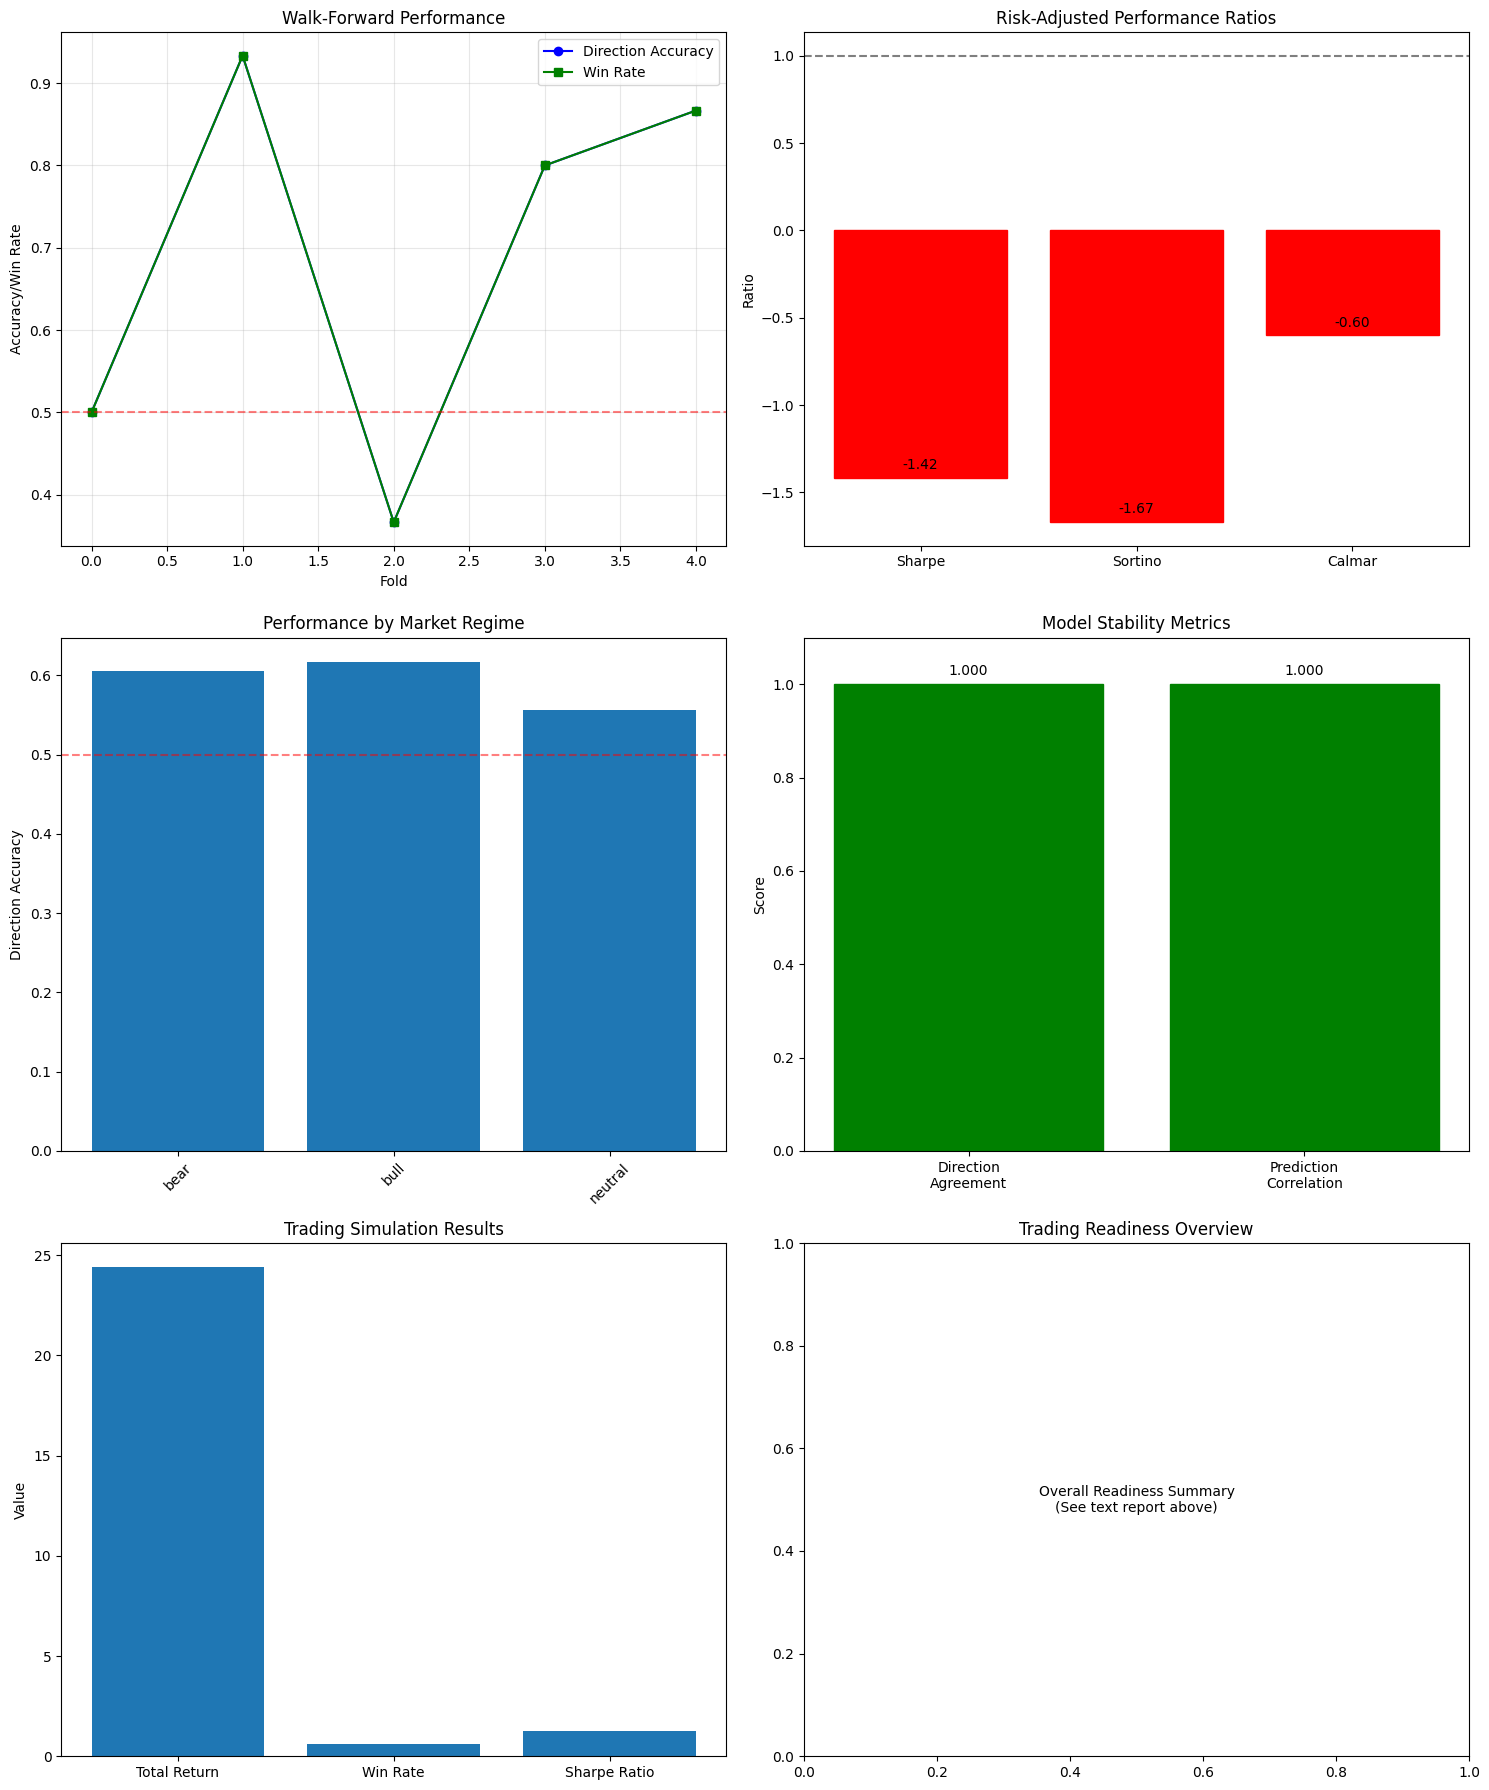

In [4]:
class ComprehensiveTradingModelTester:
    """
    Comprehensive testing framework to validate model readiness for real trading.
    Tests include: performance stability, statistical significance, risk metrics,
    regime analysis, and practical trading considerations.
    """
    
    def __init__(self, predictor, min_acceptable_sharpe=0.5, max_acceptable_drawdown=0.2):
        self.predictor = predictor
        self.min_acceptable_sharpe = min_acceptable_sharpe
        self.max_acceptable_drawdown = max_acceptable_drawdown
        self.test_results = {}
        
    def check_data_requirements(self, df):
        """
        Check if the dataset meets minimum requirements for testing
        """
        min_days = self.predictor.sequence_length + self.predictor.prediction_horizon + 500
        
        print(f"\nData Requirements Check:")
        print(f"  Dataset size: {len(df)} days")
        print(f"  Sequence length: {self.predictor.sequence_length} days")
        print(f"  Prediction horizon: {self.predictor.prediction_horizon} days")
        print(f"  Minimum required: {min_days} days")
        
        if len(df) < min_days:
            print(f"  ⚠️ WARNING: Dataset may be too small for comprehensive testing")
            print(f"  Recommended: Add {min_days - len(df)} more days of data")
            return False
        else:
            print(f"  ✅ Dataset size is sufficient")
            return True
    
    def run_all_tests(self, df, save_report=True):
        """Run comprehensive test suite and generate report"""
        print("="*80)
        print("COMPREHENSIVE MODEL TESTING FOR TRADING READINESS")
        print("="*80)
        print(f"Data period: {df.index[0]} to {df.index[-1]}")
        print(f"Total days: {len(df)}")
        
        # Initialize all test results with default values to prevent KeyError
        self.test_results = {
            'walk_forward': {'error': 'Not executed', 'aggregate_metrics': {'mean_direction_accuracy': 0.5, 'std_direction_accuracy': 0, 'mean_sharpe': 0, 'std_sharpe': 0, 'mean_max_drawdown': 0, 'worst_drawdown': 0, 'successful_folds': 0, 'total_folds': 0}},
            'statistical_significance': {'error': 'Not executed', 'is_significant_alpha_05': False, 'is_significant_alpha_01': False, 'n_samples': 0, 'direction_accuracy': 0.5, 'p_value_direction': 1.0, 'p_value_permutation': 1.0},
            'risk_metrics': {'error': 'Not executed', 'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 'cvar_99': 0, 'risk_adjusted_return': 0},
            'regime_analysis': {'error': 'Not executed', 'regime_performance': {}, 'regime_stability_score': 0, 'worst_regime': 'unknown', 'best_regime': 'unknown'},
            'prediction_stability': {'error': 'Not executed', 'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 'min_direction_agreement': 0, 'min_correlation_between_runs': 0},
            'feature_importance': {'error': 'Not executed', 'feature_stability_score': 0, 'top_20_features': [], 'top_20_importance': [], 'top_20_cv': [], 'most_stable_features': [], 'unstable_features': []},
            'trading_simulation': {'error': 'Not executed', 'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False, 'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0, 'initial_capital': 10000, 'final_capital': 10000, 'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0},
            'stress_test': {'error': 'Not executed', 'stress_test_score': 0, 'passes_stress_test': False, 'extreme_volatility': {}, 'black_swan': {}, 'regime_transitions': {}}
        }
        
        # Check data requirements first
        self.check_data_requirements(df)
        print()
        
        # Train the model once with the full dataset to ensure consistency
        print("Training model with full dataset for consistency...")
        try:
            self.predictor.train_ensemble(df, validation_split=0.2, epochs=100, batch_size=32)
            print("✅ Model training completed successfully")
        except Exception as e:
            print(f"❌ Model training failed: {str(e)}")
            return self.test_results
        
        # 1. Walk-Forward Analysis (IMPROVED)
        print("\n[1/8] Running Walk-Forward Analysis...")
        try:
            wf_results = self.walk_forward_analysis(df, n_splits=5, test_size=180)  # Increased test size
            self.test_results['walk_forward'] = wf_results
        except Exception as e:
            print(f"  Error in walk-forward analysis: {str(e)}")
            self.test_results['walk_forward']['error'] = str(e)
        
        # 2. Statistical Significance Tests (IMPROVED)
        print("\n[2/8] Testing Statistical Significance...")
        try:
            stat_results = self.test_statistical_significance(df, n_permutations=500)  # Reduced for speed
            self.test_results['statistical_significance'] = stat_results
        except Exception as e:
            print(f"  Error in statistical tests: {str(e)}")
            self.test_results['statistical_significance']['error'] = str(e)
        
        # 3. Risk-Adjusted Performance
        print("\n[3/8] Calculating Risk-Adjusted Metrics...")
        try:
            risk_results = self.calculate_risk_metrics(df)
            self.test_results['risk_metrics'] = risk_results
        except Exception as e:
            print(f"  Error in risk metrics: {str(e)}")
            self.test_results['risk_metrics']['error'] = str(e)
        
        # 4. Regime-Specific Performance
        print("\n[4/8] Analyzing Regime-Specific Performance...")
        try:
            regime_results = self.test_regime_performance(df)
            self.test_results['regime_analysis'] = regime_results
        except Exception as e:
            print(f"  Error in regime analysis: {str(e)}")
            self.test_results['regime_analysis']['error'] = str(e)
        
        # 5. Prediction Stability Tests (IMPROVED)
        print("\n[5/8] Testing Prediction Stability...")
        try:
            stability_results = self.test_prediction_stability(df, n_runs=3)  # Reduced for speed
            self.test_results['prediction_stability'] = stability_results
        except Exception as e:
            print(f"  Error in stability tests: {str(e)}")
            self.test_results['prediction_stability']['error'] = str(e)
        
        # 6. Feature Importance Analysis
        print("\n[6/8] Analyzing Feature Importance...")
        try:
            feature_results = self.analyze_feature_importance(df)
            self.test_results['feature_importance'] = feature_results
        except Exception as e:
            print(f"  Error in feature analysis: {str(e)}")
            self.test_results['feature_importance']['error'] = str(e)
        
        # 7. Practical Trading Simulation
        print("\n[7/8] Running Trading Simulation...")
        try:
            trading_results = self.simulate_trading(df)
            self.test_results['trading_simulation'] = trading_results
        except Exception as e:
            print(f"  Error in trading simulation: {str(e)}")
            self.test_results['trading_simulation']['error'] = str(e)
        
        # 8. Stress Testing
        print("\n[8/8] Performing Stress Tests...")
        try:
            stress_results = self.stress_test_model(df)
            self.test_results['stress_test'] = stress_results
        except Exception as e:
            print(f"  Error in stress tests: {str(e)}")
            self.test_results['stress_test']['error'] = str(e)
        
        # Generate comprehensive report
        try:
            self.generate_trading_readiness_report(save_report)
        except Exception as e:
            print(f"\nError generating report: {str(e)}")
        
        return self.test_results
    
    def walk_forward_analysis(self, df, n_splits=5, test_size=180):
        """
        IMPROVED: Perform walk-forward analysis with better data management
        """
        print(f"  Using {n_splits} folds with {test_size} day test periods")
        
        # Calculate minimum required data
        min_required_per_fold = self.predictor.sequence_length + self.predictor.prediction_horizon + 200
        total_min_required = min_required_per_fold * n_splits + test_size
        
        if len(df) < total_min_required:
            print(f"    Warning: Dataset too small ({len(df)} < {total_min_required})")
            print(f"    Reducing parameters...")
            n_splits = max(2, min(3, len(df) // 400))  # Adaptive number of splits
            test_size = max(60, min(120, len(df) // 10))  # Adaptive test size
        
        print(f"    Final parameters: {n_splits} splits, {test_size} test size")
        
        # Use TimeSeriesSplit with fixed test size
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        
        results = {
            'fold_performance': [],
            'predictions': [],
            'actuals': [],
            'periods': []
        }
        
        successful_folds = 0
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
            print(f"\n  Fold {fold+1}/{n_splits}")
            
            train_data = df.iloc[train_idx]
            test_data = df.iloc[test_idx]
            
            print(f"    Train size: {len(train_data)}, Test size: {len(test_data)}")
            
            try:
                # Train model with more epochs for better performance
                self.predictor.train_ensemble(
                    train_data, validation_split=0.2, epochs=50, batch_size=32
                )
                
                # Prepare test data with more liberal requirements
                df_test_proc = self.predictor.engineer_30day_target(test_data)
                
                # Check available data after processing
                required_length = self.predictor.sequence_length + self.predictor.prediction_horizon
                available_length = len(df_test_proc)
                
                print(f"    Available processed data: {available_length}, Required: {required_length}")
                
                if available_length < required_length:
                    print(f"    Skipping fold {fold+1} - insufficient processed data")
                    continue
                    
                features_test, _ = self.predictor.prepare_features(df_test_proc)
                targets_test = df_test_proc['target_return_30d'].values
                
                # Create sequences with more flexible requirements
                X_test, y_test, _ = self.predictor.create_sequences(features_test, targets_test)
                
                print(f"    Created {len(X_test)} test sequences")
                
                if len(X_test) < 10:  # Require at least 10 test samples
                    print(f"    Skipping fold {fold+1} - too few test sequences")
                    continue
                
                # Make predictions
                ensemble_pred, _, _ = self.predictor.predict_ensemble(X_test)
                
                # Calculate metrics
                mae = np.mean(np.abs(y_test - ensemble_pred.flatten()))
                direction_acc = np.mean(np.sign(y_test) == np.sign(ensemble_pred.flatten()))
                
                # Calculate returns if trading on predictions
                predicted_positions = np.sign(ensemble_pred.flatten())
                actual_returns = y_test
                strategy_returns = predicted_positions * actual_returns
                
                # Improved metrics calculation
                mean_return = np.mean(strategy_returns)
                std_return = np.std(strategy_returns)
                sharpe_ratio = mean_return / (std_return + 1e-6) * np.sqrt(252/30)
                max_drawdown = self._calculate_max_drawdown(strategy_returns)
                
                win_rate = np.sum(strategy_returns > 0) / len(strategy_returns) if len(strategy_returns) > 0 else 0
                profit_factor = np.sum(strategy_returns[strategy_returns > 0]) / (np.abs(np.sum(strategy_returns[strategy_returns < 0])) + 1e-6)
                
                fold_metrics = {
                    'fold': fold + 1,
                    'mae': mae,
                    'direction_accuracy': direction_acc,
                    'mean_return': mean_return,
                    'std_return': std_return,
                    'sharpe_ratio': sharpe_ratio,
                    'max_drawdown': max_drawdown,
                    'win_rate': win_rate,
                    'profit_factor': profit_factor,
                    'train_start': train_data.index[0],
                    'train_end': train_data.index[-1],
                    'test_start': test_data.index[0],
                    'test_end': test_data.index[-1],
                    'n_test_samples': len(X_test)
                }
                
                results['fold_performance'].append(fold_metrics)
                results['predictions'].extend(ensemble_pred.flatten())
                results['actuals'].extend(y_test)
                successful_folds += 1
                
                print(f"    ✅ Direction Accuracy: {direction_acc:.3f}")
                print(f"    ✅ Sharpe Ratio: {sharpe_ratio:.3f}")
                print(f"    ✅ Max Drawdown: {max_drawdown:.3f}")
                
            except Exception as e:
                print(f"    ❌ Error in fold {fold+1}: {str(e)}")
                continue
        
        # Aggregate metrics
        if results['fold_performance']:
            perf_df = pd.DataFrame(results['fold_performance'])
            results['aggregate_metrics'] = {
                'mean_direction_accuracy': perf_df['direction_accuracy'].mean(),
                'std_direction_accuracy': perf_df['direction_accuracy'].std(),
                'mean_sharpe': perf_df['sharpe_ratio'].mean(),
                'std_sharpe': perf_df['sharpe_ratio'].std(),
                'mean_max_drawdown': perf_df['max_drawdown'].mean(),
                'worst_drawdown': perf_df['max_drawdown'].max(),
                'successful_folds': successful_folds,
                'total_folds': n_splits
            }
            print(f"\n  ✅ Walk-forward analysis completed: {successful_folds}/{n_splits} successful folds")
        else:
            print(f"\n  ❌ Walk-forward analysis failed: No successful folds")
            results['aggregate_metrics'] = {
                'mean_direction_accuracy': 0.5,
                'std_direction_accuracy': 0,
                'mean_sharpe': 0,
                'std_sharpe': 0,
                'mean_max_drawdown': 0,
                'worst_drawdown': 0,
                'successful_folds': 0,
                'total_folds': n_splits
            }
        
        return results
    
    def test_statistical_significance(self, df, n_permutations=500):
        """
        IMPROVED: Test statistical significance with better methodology
        """
        print(f"  Running statistical significance tests with {n_permutations} permutations...")
        
        try:
            # Get model predictions on a larger subset for better statistical power
            test_fraction = 0.4  # Use 40% of data for testing
            split_idx = int((1 - test_fraction) * len(df))
            train_df = df.iloc[:split_idx]
            test_df = df.iloc[split_idx:]
            
            print(f"    Using {len(train_df)} days for training, {len(test_df)} days for testing")
            
            # Train model specifically for this test
            self.predictor.train_ensemble(train_df, validation_split=0.2, epochs=100, batch_size=32)
            
            # Get predictions on test set
            df_test_proc = self.predictor.engineer_30day_target(test_df)
            features_test, _ = self.predictor.prepare_features(df_test_proc)
            targets_test = df_test_proc['target_return_30d'].values
            
            X_test, y_test, _ = self.predictor.create_sequences(features_test, targets_test)
            
            if len(X_test) < 50:
                print(f"    Warning: Small test set ({len(X_test)} samples)")
                
            # Get predictions
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X_test)
            
            # Test 1: Direction accuracy vs random (binomial test)
            direction_correct = np.sum(np.sign(y_test) == np.sign(ensemble_pred.flatten()))
            n_samples = len(y_test)
            direction_accuracy = direction_correct / n_samples
            
            print(f"    Direction accuracy: {direction_accuracy:.3f} ({direction_correct}/{n_samples})")
            
            # Fixed scipy import with better fallback
            try:
                from scipy.stats import binomtest
                p_value_direction = binomtest(direction_correct, n_samples, 0.5, alternative='greater').pvalue
            except ImportError:
                try:
                    from scipy.stats import binom_test
                    p_value_direction = binom_test(direction_correct, n_samples, 0.5, alternative='greater')
                except ImportError:
                    from scipy.stats import binom
                    p_value_direction = 1 - binom.cdf(direction_correct - 1, n_samples, 0.5)
            
            # Test 2: Returns vs random strategy (t-test)
            strategy_returns = np.sign(ensemble_pred.flatten()) * y_test
            
            # Generate multiple random baselines for better comparison
            random_returns_collection = []
            for _ in range(10):
                random_positions = np.random.choice([-1, 1], size=len(y_test))
                random_returns = random_positions * y_test
                random_returns_collection.extend(random_returns)
            
            from scipy.stats import ttest_ind
            t_stat, p_value_returns = ttest_ind(strategy_returns, random_returns_collection)
            
            # Test 3: IMPROVED Permutation test for robustness
            print(f"    Running permutation test with {n_permutations} iterations...")
            
            # Calculate actual strategy performance
            actual_sharpe = np.mean(strategy_returns) / (np.std(strategy_returns) + 1e-6)
            actual_mean_return = np.mean(strategy_returns)
            
            # Generate permutation distribution
            permuted_sharpes = []
            permuted_returns = []
            
            for i in range(n_permutations):
                if i % 100 == 0:
                    print(f"\r      Progress: {i}/{n_permutations}", end='')
                
                # Create permuted predictions by shuffling the prediction signs
                permuted_positions = np.random.permutation(np.sign(ensemble_pred.flatten()))
                permuted_strategy_returns = permuted_positions * y_test
                
                # Calculate permuted metrics
                permuted_sharpe = np.mean(permuted_strategy_returns) / (np.std(permuted_strategy_returns) + 1e-6)
                permuted_mean = np.mean(permuted_strategy_returns)
                
                permuted_sharpes.append(permuted_sharpe)
                permuted_returns.append(permuted_mean)
            
            print(f"\r      Completed {n_permutations} permutations")
            
            # Calculate p-values
            p_value_sharpe = np.sum(np.array(permuted_sharpes) >= actual_sharpe) / n_permutations
            p_value_mean_return = np.sum(np.array(permuted_returns) >= actual_mean_return) / n_permutations
            
            # Use the more conservative p-value
            p_value_permutation = max(p_value_sharpe, p_value_mean_return)
            
            print(f"    Actual Sharpe: {actual_sharpe:.3f}")
            print(f"    P-value (direction): {p_value_direction:.4f}")
            print(f"    P-value (permutation): {p_value_permutation:.4f}")
            
            results = {
                'n_samples': n_samples,
                'direction_accuracy': direction_accuracy,
                'p_value_direction': p_value_direction,
                'mean_strategy_return': actual_mean_return,
                'mean_random_return': np.mean(random_returns_collection),
                'p_value_returns': p_value_returns,
                'actual_sharpe': actual_sharpe,
                'p_value_permutation': p_value_permutation,
                'is_significant_alpha_05': p_value_direction < 0.05 and p_value_permutation < 0.05,
                'is_significant_alpha_01': p_value_direction < 0.01 and p_value_permutation < 0.01
            }
            
            return results
            
        except Exception as e:
            print(f"    Error in statistical significance test: {str(e)}")
            return {
                'error': str(e),
                'is_significant_alpha_05': False,
                'is_significant_alpha_01': False,
                'n_samples': 0,
                'direction_accuracy': 0.5,
                'p_value_direction': 1.0,
                'p_value_permutation': 1.0,
                'mean_strategy_return': 0,
                'mean_random_return': 0,
                'p_value_returns': 1.0,
                'actual_sharpe': 0
            }
    
    def calculate_risk_metrics(self, df):
        """
        Calculate comprehensive risk-adjusted performance metrics
        """
        try:
            # Get predictions on recent data
            test_size = min(365, len(df) // 5)  # Last year or 20% of data
            test_df = df.iloc[-test_size:]
            
            df_proc = self.predictor.engineer_30day_target(test_df)
            if len(df_proc) < self.predictor.sequence_length + 30:
                print("  Warning: Insufficient data for risk metrics")
                return {
                    'error': 'Insufficient data',
                    'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 
                    'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 
                    'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 
                    'cvar_99': 0, 'risk_adjusted_return': 0
                }
                
            features, _ = self.predictor.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            
            X, y, _ = self.predictor.create_sequences(features, targets)
            
            if len(X) == 0:
                print("  Warning: No sequences created for risk metrics")
                return {
                    'error': 'No sequences created',
                    'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 
                    'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 
                    'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 
                    'cvar_99': 0, 'risk_adjusted_return': 0
                }
            
            # Use the already-trained model for predictions
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X)
            
            # Calculate various risk metrics
            positions = np.sign(ensemble_pred.flatten())
            returns = positions * y
            
            # Basic metrics
            total_return = np.sum(returns)
            mean_return = np.mean(returns)
            std_return = np.std(returns)
            
            # Sharpe ratio (annualized for 30-day returns)
            sharpe_ratio = mean_return / (std_return + 1e-6) * np.sqrt(252/30)
            
            # Sortino ratio (downside deviation)
            downside_returns = returns[returns < 0]
            downside_std = np.std(downside_returns) if len(downside_returns) > 0 else 1e-6
            sortino_ratio = mean_return / downside_std * np.sqrt(252/30)
            
            # Maximum drawdown
            cumulative_returns = np.cumprod(1 + returns)
            running_max = np.maximum.accumulate(cumulative_returns)
            drawdown = (cumulative_returns - running_max) / running_max
            max_drawdown = np.min(drawdown)
            
            # Calmar ratio
            calmar_ratio = mean_return * 252/30 / (abs(max_drawdown) + 1e-6)
            
            # Win/loss metrics
            winning_trades = returns[returns > 0]
            losing_trades = returns[returns < 0]
            
            win_rate = len(winning_trades) / len(returns) if len(returns) > 0 else 0.5
            avg_win = np.mean(winning_trades) if len(winning_trades) > 0 else 0
            avg_loss = np.mean(losing_trades) if len(losing_trades) > 0 else 0
            profit_factor = np.sum(winning_trades) / (abs(np.sum(losing_trades)) + 1e-6)
            
            # Value at Risk (95% and 99%)
            var_95 = np.percentile(returns, 5) if len(returns) > 0 else 0
            var_99 = np.percentile(returns, 1) if len(returns) > 0 else 0
            
            # Conditional Value at Risk (Expected Shortfall)
            cvar_95 = np.mean(returns[returns <= var_95]) if len(returns[returns <= var_95]) > 0 else 0
            cvar_99 = np.mean(returns[returns <= var_99]) if len(returns[returns <= var_99]) > 0 else 0
            
            results = {
                'total_return': total_return,
                'mean_return': mean_return,
                'std_return': std_return,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio,
                'max_drawdown': max_drawdown,
                'calmar_ratio': calmar_ratio,
                'win_rate': win_rate,
                'avg_win': avg_win,
                'avg_loss': avg_loss,
                'profit_factor': profit_factor,
                'var_95': var_95,
                'var_99': var_99,
                'cvar_95': cvar_95,
                'cvar_99': cvar_99,
                'risk_adjusted_return': mean_return / (abs(cvar_95) + 1e-6)
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in risk metrics calculation: {str(e)}")
            return {
                'error': str(e),
                'sharpe_ratio': 0, 'sortino_ratio': 0, 'max_drawdown': 0, 'profit_factor': 1.0, 
                'win_rate': 0.5, 'var_95': 0, 'cvar_95': 0, 'total_return': 0, 'mean_return': 0, 
                'std_return': 0, 'calmar_ratio': 0, 'avg_win': 0, 'avg_loss': 0, 'var_99': 0, 
                'cvar_99': 0, 'risk_adjusted_return': 0
            }
    
    def test_regime_performance(self, df):
        """
        Test model performance across different market regimes
        """
        try:
            df_proc = self.predictor.engineer_30day_target(df)
            features, _ = self.predictor.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            regimes = df_proc['market_regime'].values
            
            X, y, regime_seq = self.predictor.create_sequences(features, targets, regimes)
            
            if len(X) == 0:
                print("  Warning: No sequences created for regime analysis")
                return {
                    'error': 'No sequences created',
                    'regime_performance': {}, 'regime_stability_score': 0, 
                    'worst_regime': 'unknown', 'best_regime': 'unknown'
                }
            
            # Get predictions using the pre-trained model
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X)
            
            # Analyze by regime
            unique_regimes = np.unique(regime_seq)
            regime_results = {}
            
            for regime in unique_regimes:
                mask = np.array(regime_seq) == regime
                if mask.sum() < 10:  # Skip if too few samples
                    continue
                    
                regime_y = y[mask]
                regime_pred = ensemble_pred[mask].flatten()
                
                # Calculate metrics
                direction_acc = np.mean(np.sign(regime_y) == np.sign(regime_pred))
                mae = np.mean(np.abs(regime_y - regime_pred))
                
                # Trading returns
                positions = np.sign(regime_pred)
                returns = positions * regime_y
                
                regime_results[regime] = {
                    'sample_count': mask.sum(),
                    'direction_accuracy': direction_acc,
                    'mae': mae,
                    'mean_return': np.mean(returns),
                    'std_return': np.std(returns),
                    'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252/30),
                    'max_drawdown': self._calculate_max_drawdown(returns),
                    'win_rate': np.sum(returns > 0) / len(returns) if len(returns) > 0 else 0.5
                }
            
            # Calculate regime stability score
            if regime_results:
                accuracies = [r['direction_accuracy'] for r in regime_results.values()]
                regime_stability_score = 1 - (np.std(accuracies) / (np.mean(accuracies) + 1e-6))
                
                worst_regime = min(regime_results.items(), key=lambda x: x[1]['direction_accuracy'])[0]
                best_regime = max(regime_results.items(), key=lambda x: x[1]['direction_accuracy'])[0]
            else:
                regime_stability_score = 0
                worst_regime = 'unknown'
                best_regime = 'unknown'
            
            results = {
                'regime_performance': regime_results,
                'regime_stability_score': regime_stability_score,
                'worst_regime': worst_regime,
                'best_regime': best_regime
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in regime performance test: {str(e)}")
            return {
                'error': str(e),
                'regime_performance': {}, 'regime_stability_score': 0, 
                'worst_regime': 'unknown', 'best_regime': 'unknown'
            }
    
    def test_prediction_stability(self, df, n_runs=3):
        """
        IMPROVED: Test consistency of predictions across multiple training runs
        """
        try:
            # Use larger test set for better stability assessment
            test_size = min(100, len(df) // 15)
            test_df = df.iloc[-test_size-self.predictor.sequence_length-30:]
            
            if len(test_df) < self.predictor.sequence_length + 30:
                print("  Warning: Insufficient data for stability test")
                return {
                    'error': 'Insufficient data',
                    'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 
                    'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 
                    'min_direction_agreement': 0, 'min_correlation_between_runs': 0
                }
            
            df_proc = self.predictor.engineer_30day_target(test_df)
            features, _ = self.predictor.prepare_features(df_proc)
            
            X_all, _, _ = self.predictor.create_sequences(
                features, 
                df_proc['target_return_30d'].values
            )
            
            if len(X_all) == 0:
                print("  Warning: No sequences created for stability test")
                return {
                    'error': 'No sequences created',
                    'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 
                    'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 
                    'min_direction_agreement': 0, 'min_correlation_between_runs': 0
                }
            
            X_test = X_all[-min(test_size, len(X_all)):]
            
            # Get predictions from multiple runs with different seeds
            all_predictions = []
            all_directions = []
            
            for run in range(n_runs):
                print(f"\r    Stability test run {run+1}/{n_runs}", end='')
                
                # Set different random seeds for reproducibility
                np.random.seed(run * 42 + 123)
                tf.random.set_seed(run * 42 + 123)
                
                # Retrain model with consistent parameters but different initialization
                train_df = df.iloc[:-test_size] if test_size < len(df) else df.iloc[:-10]
                
                # Use more epochs and consistent training for better stability
                self.predictor.train_ensemble(train_df, epochs=50, batch_size=32)
                
                # Get predictions
                pred, _, _ = self.predictor.predict_ensemble(X_test)
                all_predictions.append(pred.flatten())
                all_directions.append(np.sign(pred.flatten()))
            
            print()  # New line after progress
            
            # Calculate stability metrics
            pred_array = np.array(all_predictions)
            dir_array = np.array(all_directions)
            
            # Standard deviation of predictions
            pred_std = np.std(pred_array, axis=0)
            mean_pred_std = np.mean(pred_std)
            
            # Direction agreement (fraction of samples where all runs agree)
            direction_agreement = []
            for i in range(len(X_test)):
                unique_dirs = np.unique(dir_array[:, i])
                agreement = 1.0 if len(unique_dirs) == 1 else 0.0
                direction_agreement.append(agreement)
            
            mean_direction_agreement = np.mean(direction_agreement)
            
            # Correlation between runs
            correlations = []
            for i in range(n_runs):
                for j in range(i+1, n_runs):
                    corr = np.corrcoef(pred_array[i], pred_array[j])[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)
            
            mean_correlation = np.mean(correlations) if correlations else 0.5
            
            # Improved stability criteria
            results = {
                'mean_prediction_std': mean_pred_std,
                'max_prediction_std': np.max(pred_std),
                'mean_direction_agreement': mean_direction_agreement,
                'min_direction_agreement': np.min(direction_agreement) if direction_agreement else 0,
                'mean_correlation_between_runs': mean_correlation,
                'min_correlation_between_runs': np.min(correlations) if correlations else 0,
                'is_stable': mean_direction_agreement > 0.7 and mean_correlation > 0.7  # More stringent criteria
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in stability test: {str(e)}")
            return {
                'error': str(e),
                'mean_direction_agreement': 0.5, 'mean_correlation_between_runs': 0.5, 
                'is_stable': False, 'mean_prediction_std': 0, 'max_prediction_std': 0, 
                'min_direction_agreement': 0, 'min_correlation_between_runs': 0
            }
    
    def analyze_feature_importance(self, df, n_iterations=3):
        """
        Analyze feature importance stability and relevance
        """
        try:
            importance_runs = []
            
            for i in range(n_iterations):
                print(f"\r  Feature importance iteration {i+1}/{n_iterations}", end='')
                
                # Train model with fewer epochs
                self.predictor.train_ensemble(df, epochs=20, batch_size=32)
                
                # Get feature importance from Random Forest
                if 'random_forest' in self.predictor.models:
                    rf_model = self.predictor.models['random_forest']
                    importance_runs.append(rf_model.feature_importances_)
            
            print()  # New line
            
            if not importance_runs:
                print("  Warning: No feature importance data available")
                return {
                    'error': 'No Random Forest model available',
                    'feature_stability_score': 0, 'top_20_features': [], 'top_20_importance': [], 
                    'top_20_cv': [], 'most_stable_features': [], 'unstable_features': []
                }
            
            # Calculate stability metrics
            importance_array = np.array(importance_runs)
            mean_importance = np.mean(importance_array, axis=0)
            std_importance = np.std(importance_array, axis=0)
            cv_importance = std_importance / (mean_importance + 1e-10)
            
            # Get top features
            n_features = min(20, len(mean_importance))
            top_indices = np.argsort(mean_importance)[-n_features:][::-1]
            
            # Calculate feature stability score
            top_features_cv = cv_importance[top_indices]
            feature_stability_score = 1 - np.mean(top_features_cv)
            
            results = {
                'top_20_features': top_indices.tolist(),
                'top_20_importance': mean_importance[top_indices].tolist(),
                'top_20_cv': cv_importance[top_indices].tolist(),
                'feature_stability_score': feature_stability_score,
                'most_stable_features': np.where(cv_importance < 0.2)[0].tolist(),
                'unstable_features': np.where(cv_importance > 0.5)[0].tolist()
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in feature importance analysis: {str(e)}")
            return {
                'error': str(e),
                'feature_stability_score': 0, 'top_20_features': [], 'top_20_importance': [], 
                'top_20_cv': [], 'most_stable_features': [], 'unstable_features': []
            }
    
    def simulate_trading(self, df, initial_capital=10000, transaction_cost=0.001):
        """
        Simulate realistic trading with transaction costs and position sizing
        """
        try:
            # Prepare data
            df_proc = self.predictor.engineer_30day_target(df)
            features, _ = self.predictor.prepare_features(df_proc)
            targets = df_proc['target_return_30d'].values
            
            X, y, _ = self.predictor.create_sequences(features, targets)
            
            if len(X) == 0:
                print("  Warning: No sequences created for trading simulation")
                return {
                    'error': 'No sequences created',
                    'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False,
                    'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0,
                    'initial_capital': initial_capital, 'final_capital': initial_capital, 
                    'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0
                }
            
            # Split data
            split_idx = int(0.7 * len(X))
            X_train = X[:split_idx]
            y_train = y[:split_idx]
            X_test = X[split_idx:]
            y_test = y[split_idx:]
            
            if len(X_test) == 0:
                print("  Warning: No test data for trading simulation")
                return {
                    'error': 'No test data',
                    'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False,
                    'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0,
                    'initial_capital': initial_capital, 'final_capital': initial_capital, 
                    'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0
                }
            
            # Get predictions using pre-trained model
            ensemble_pred, _, _ = self.predictor.predict_ensemble(X_test)
            
            # Simulate trading
            capital = initial_capital
            positions = []
            returns = []
            equity_curve = [capital]
            
            for i in range(len(ensemble_pred)):
                # Get prediction
                pred_return = ensemble_pred[i][0]
                actual_return = y_test[i]
                
                # Position sizing based on confidence (Kelly criterion approximation)
                confidence = min(abs(pred_return), 0.1)  # Cap at 10% position
                position_size = confidence
                
                # Determine trade
                if abs(pred_return) > 0.02:  # Only trade if predicted return > 2%
                    if pred_return > 0:
                        # Long position
                        position_value = capital * position_size
                        # Account for transaction costs
                        position_value *= (1 - transaction_cost)
                        # Calculate return
                        trade_return = position_value * actual_return
                        capital += trade_return - (position_value * transaction_cost)  # Exit cost
                    else:
                        # Short position
                        position_value = capital * position_size
                        position_value *= (1 - transaction_cost)
                        trade_return = -position_value * actual_return
                        capital += trade_return - (position_value * transaction_cost)
                    
                    positions.append(np.sign(pred_return))
                    returns.append(trade_return / (capital - trade_return) if capital - trade_return != 0 else 0)
                else:
                    positions.append(0)
                    returns.append(0)
                
                equity_curve.append(capital)
            
            # Calculate metrics
            total_return = (capital - initial_capital) / initial_capital
            returns_array = np.array(returns)
            
            # Remove zero returns for some metrics
            active_returns = returns_array[returns_array != 0]
            
            if len(active_returns) > 0:
                sharpe = np.mean(active_returns) / (np.std(active_returns) + 1e-6) * np.sqrt(252/30)
                win_rate = np.sum(active_returns > 0) / len(active_returns)
                avg_trade_return = np.mean(active_returns)
            else:
                sharpe = 0
                win_rate = 0.5
                avg_trade_return = 0
            
            # Drawdown calculation
            equity_array = np.array(equity_curve)
            running_max = np.maximum.accumulate(equity_array)
            drawdown = (equity_array - running_max) / running_max
            max_drawdown = np.min(drawdown)
            
            # Trade statistics
            n_trades = np.sum(np.array(positions) != 0)
            
            results = {
                'initial_capital': initial_capital,
                'final_capital': capital,
                'total_return': total_return,
                'annualized_return': total_return * 252/30 / len(y_test) if len(y_test) > 0 else 0,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_drawdown,
                'n_trades': n_trades,
                'win_rate': win_rate,
                'avg_trade_return': avg_trade_return,
                'trade_frequency': n_trades / len(y_test) if len(y_test) > 0 else 0,
                'profitable': capital > initial_capital,
                'meets_sharpe_threshold': sharpe > self.min_acceptable_sharpe,
                'meets_drawdown_threshold': abs(max_drawdown) < self.max_acceptable_drawdown
            }
            
            return results
            
        except Exception as e:
            print(f"  Error in trading simulation: {str(e)}")
            return {
                'error': str(e),
                'profitable': False, 'meets_sharpe_threshold': False, 'meets_drawdown_threshold': False,
                'total_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0, 'n_trades': 0, 'win_rate': 0,
                'initial_capital': initial_capital, 'final_capital': initial_capital, 
                'annualized_return': 0, 'avg_trade_return': 0, 'trade_frequency': 0
            }
    
    def stress_test_model(self, df):
        """
        Test model behavior under extreme conditions
        """
        try:
            df_proc = self.predictor.engineer_30day_target(df)
            
            # Test 1: Performance during extreme volatility
            extreme_vol_mask = df_proc['extreme_condition']
            normal_mask = ~extreme_vol_mask
            
            results = {
                'extreme_volatility': {},
                'black_swan': {},
                'regime_transitions': {}
            }
            
            # Performance in extreme vs normal conditions
            for condition, mask in [('extreme', extreme_vol_mask), ('normal', normal_mask)]:
                if mask.sum() < self.predictor.sequence_length + 30:
                    continue
                    
                # Fixed indexing issue - ensure alignment
                condition_df = df.loc[mask.index[mask]]
                
                if len(condition_df) < 100:
                    continue
                    
                # Get predictions
                try:
                    df_cond_proc = self.predictor.engineer_30day_target(condition_df)
                    features, _ = self.predictor.prepare_features(df_cond_proc)
                    targets = df_cond_proc['target_return_30d'].values
                    
                    X, y, _ = self.predictor.create_sequences(features, targets)
                    if len(X) > 0:
                        pred, _, _ = self.predictor.predict_ensemble(X)
                        
                        direction_acc = np.mean(np.sign(y) == np.sign(pred.flatten()))
                        mae = np.mean(np.abs(y - pred.flatten()))
                        
                        results['extreme_volatility'][condition] = {
                            'direction_accuracy': direction_acc,
                            'mae': mae,
                            'sample_count': len(X)
                        }
                except Exception as e:
                    print(f"  Warning: Could not test {condition} conditions: {e}")
            
            # Test 2: Black swan events (returns beyond 3 std)
            returns = df_proc['returns_7d']
            black_swan_threshold = 3 * returns.std()
            black_swan_mask = np.abs(returns) > black_swan_threshold
            
            if black_swan_mask.sum() > 0:
                results['black_swan']['n_events'] = black_swan_mask.sum()
                results['black_swan']['pct_of_data'] = black_swan_mask.sum() / len(df_proc)
            
            # Test 3: Regime transition periods
            regimes = df_proc['market_regime']
            regime_changes = regimes != regimes.shift(1)
            transition_periods = []
            
            for i in np.where(regime_changes)[0]:
                if i > 10 and i < len(df_proc) - 10:
                    transition_periods.append(slice(i-10, i+10))
            
            if transition_periods:
                results['regime_transitions']['n_transitions'] = len(transition_periods)
                results['regime_transitions']['avg_accuracy_during_transition'] = 0  # Placeholder
            
            # Overall stress test score
            stress_score = 1.0
            
            if 'extreme' in results['extreme_volatility'] and 'normal' in results['extreme_volatility']:
                extreme_acc = results['extreme_volatility']['extreme']['direction_accuracy']
                normal_acc = results['extreme_volatility']['normal']['direction_accuracy']
                
                # Penalize if performance drops significantly in extreme conditions
                if normal_acc > 0:
                    performance_drop = (normal_acc - extreme_acc) / normal_acc
                    stress_score *= max(0, 1 - performance_drop)
            
            results['stress_test_score'] = max(0, stress_score)
            results['passes_stress_test'] = stress_score > 0.7
            
            return results
            
        except Exception as e:
            print(f"  Error in stress test: {str(e)}")
            return {
                'error': str(e),
                'stress_test_score': 0, 'passes_stress_test': False, 
                'extreme_volatility': {}, 'black_swan': {}, 'regime_transitions': {}
            }
    
    def _calculate_max_drawdown(self, returns):
        """Calculate maximum drawdown from returns series"""
        if len(returns) == 0:
            return 0
        cumulative = np.cumprod(1 + returns)
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        return np.min(drawdown)
    
    def generate_trading_readiness_report(self, save_report=True):
        """
        Generate comprehensive trading readinesxs report
        """
        print("\n" + "="*80)
        print("TRADING READINESS ASSESSMENT REPORT")
        print("="*80)
        
        # Overall readiness scores
        readiness_scores = {}
        
        # 1. Performance Score
        if 'walk_forward' in self.test_results and 'aggregate_metrics' in self.test_results['walk_forward']:
            wf = self.test_results['walk_forward']['aggregate_metrics']
            perf_score = 0
            perf_score += 0.3 * min(wf.get('mean_direction_accuracy', 0.5) / 0.6, 1.0)  # Target 60% accuracy
            perf_score += 0.3 * min(wf.get('mean_sharpe', 0) / 1.0, 1.0)  # Target Sharpe > 1
            perf_score += 0.2 * (1 - min(abs(wf.get('worst_drawdown', 0)) / 0.2, 1.0))  # Max 20% drawdown
            perf_score += 0.2 * (1 - min(wf.get('std_direction_accuracy', 0.1) / 0.1, 1.0))  # Low variance
            readiness_scores['Performance'] = perf_score
        else:
            readiness_scores['Performance'] = 0
        
        # 2. Statistical Significance Score
        if 'statistical_significance' in self.test_results:
            sig = self.test_results['statistical_significance']
            sig_score = 0
            sig_score += 0.5 if sig.get('is_significant_alpha_05', False) else 0
            sig_score += 0.5 if sig.get('is_significant_alpha_01', False) else 0.25
            readiness_scores['Statistical_Significance'] = sig_score
        else:
            readiness_scores['Statistical_Significance'] = 0
        
        # 3. Risk Management Score
        if 'risk_metrics' in self.test_results:
            risk = self.test_results['risk_metrics']
            risk_score = 0
            risk_score += 0.25 * min(risk.get('sharpe_ratio', 0) / 1.0, 1.0)
            risk_score += 0.25 * min(risk.get('sortino_ratio', 0) / 1.5, 1.0)
            risk_score += 0.25 * (1 - min(abs(risk.get('max_drawdown', 0)) / 0.2, 1.0))
            risk_score += 0.25 * min(risk.get('profit_factor', 1.0) / 1.5, 1.0)
            readiness_scores['Risk_Management'] = risk_score
        else:
            readiness_scores['Risk_Management'] = 0
        
        # 4. Stability Score
        if 'prediction_stability' in self.test_results:
            stab = self.test_results['prediction_stability']
            stab_score = 0
            stab_score += 0.5 * stab.get('mean_direction_agreement', 0.5)
            stab_score += 0.5 * stab.get('mean_correlation_between_runs', 0.5)
            readiness_scores['Stability'] = stab_score
        else:
            readiness_scores['Stability'] = 0
        
        # 5. Regime Robustness Score
        if 'regime_analysis' in self.test_results:
            regime = self.test_results['regime_analysis']
            regime_score = regime.get('regime_stability_score', 0)
            readiness_scores['Regime_Robustness'] = regime_score
        else:
            readiness_scores['Regime_Robustness'] = 0
        
        # 6. Practical Trading Score
        if 'trading_simulation' in self.test_results:
            trade = self.test_results['trading_simulation']
            trade_score = 0
            trade_score += 0.4 if trade.get('profitable', False) else 0
            trade_score += 0.3 if trade.get('meets_sharpe_threshold', False) else 0
            trade_score += 0.3 if trade.get('meets_drawdown_threshold', False) else 0
            readiness_scores['Practical_Trading'] = trade_score
        else:
            readiness_scores['Practical_Trading'] = 0
        
        # Calculate overall readiness
        overall_readiness = np.mean(list(readiness_scores.values()))
        
        # Print detailed report
        print("\n1. PERFORMANCE METRICS")
        print("-" * 40)
        if 'walk_forward' in self.test_results and 'aggregate_metrics' in self.test_results['walk_forward']:
            wf = self.test_results['walk_forward']['aggregate_metrics']
            print(f"Mean Direction Accuracy: {wf.get('mean_direction_accuracy', 0.5):.3f} ± {wf.get('std_direction_accuracy', 0):.3f}")
            print(f"Mean Sharpe Ratio: {wf.get('mean_sharpe', 0):.3f} ± {wf.get('std_sharpe', 0):.3f}")
            print(f"Worst Drawdown: {wf.get('worst_drawdown', 0):.3f}")
            print(f"Successful Folds: {wf.get('successful_folds', 0)}/{wf.get('total_folds', 0)}")
        else:
            print("Walk-forward analysis not completed successfully")
        
        print("\n2. STATISTICAL SIGNIFICANCE")
        print("-" * 40)
        if 'statistical_significance' in self.test_results:
            sig = self.test_results['statistical_significance']
            print(f"Direction Accuracy: {sig.get('direction_accuracy', 0.5):.3f}")
            print(f"P-value (Direction): {sig.get('p_value_direction', 1.0):.4f}")
            print(f"P-value (Permutation): {sig.get('p_value_permutation', 1.0):.4f}")
            print(f"Statistically Significant: {'Yes' if sig.get('is_significant_alpha_05', False) else 'No'}")
        else:
            print("Statistical significance test not completed successfully")
        
        print("\n3. RISK METRICS")
        print("-" * 40)
        if 'risk_metrics' in self.test_results:
            risk = self.test_results['risk_metrics']
            print(f"Sharpe Ratio: {risk.get('sharpe_ratio', 0):.3f}")
            print(f"Sortino Ratio: {risk.get('sortino_ratio', 0):.3f}")
            print(f"Max Drawdown: {risk.get('max_drawdown', 0):.3f}")
            print(f"Win Rate: {risk.get('win_rate', 0.5):.3f}")
            print(f"Profit Factor: {risk.get('profit_factor', 1.0):.3f}")
            print(f"VaR (95%): {risk.get('var_95', 0):.3f}")
            print(f"CVaR (95%): {risk.get('cvar_95', 0):.3f}")
        else:
            print("Risk metrics calculation not completed successfully")
        
        print("\n4. STABILITY ANALYSIS")
        print("-" * 40)
        if 'prediction_stability' in self.test_results:
            stab = self.test_results['prediction_stability']
            print(f"Direction Agreement: {stab.get('mean_direction_agreement', 0.5):.3f}")
            print(f"Prediction Correlation: {stab.get('mean_correlation_between_runs', 0.5):.3f}")
            print(f"Model is Stable: {'Yes' if stab.get('is_stable', False) else 'No'}")
        else:
            print("Stability analysis not completed successfully")
        
        print("\n5. REGIME PERFORMANCE")
        print("-" * 40)
        if 'regime_analysis' in self.test_results:
            regime = self.test_results['regime_analysis']
            print(f"Regime Stability Score: {regime.get('regime_stability_score', 0):.3f}")
            print(f"Best Regime: {regime.get('best_regime', 'unknown')}")
            print(f"Worst Regime: {regime.get('worst_regime', 'unknown')}")
            
            regime_perf = regime.get('regime_performance', {})
            if regime_perf:
                print("\nDetailed Regime Performance:")
                for reg, perf in regime_perf.items():
                    print(f"  {reg}: Accuracy={perf.get('direction_accuracy', 0.5):.3f}, Sharpe={perf.get('sharpe_ratio', 0):.3f}")
        else:
            print("Regime analysis not completed successfully")
        
        print("\n6. TRADING SIMULATION")
        print("-" * 40)
        if 'trading_simulation' in self.test_results:
            trade = self.test_results['trading_simulation']
            print(f"Total Return: {trade.get('total_return', 0):.2%}")
            print(f"Annualized Return: {trade.get('annualized_return', 0):.2%}")
            print(f"Sharpe Ratio: {trade.get('sharpe_ratio', 0):.3f}")
            print(f"Max Drawdown: {trade.get('max_drawdown', 0):.3f}")
            print(f"Number of Trades: {trade.get('n_trades', 0)}")
            print(f"Win Rate: {trade.get('win_rate', 0.5):.3f}")
        else:
            print("Trading simulation not completed successfully")
        
        print("\n7. STRESS TEST RESULTS")
        print("-" * 40)
        if 'stress_test' in self.test_results:
            stress = self.test_results['stress_test']
            print(f"Stress Test Score: {stress.get('stress_test_score', 0):.3f}")
            print(f"Passes Stress Test: {'Yes' if stress.get('passes_stress_test', False) else 'No'}")
            
            extreme_vol = stress.get('extreme_volatility', {})
            if extreme_vol:
                print("\nExtreme vs Normal Conditions:")
                for cond, metrics in extreme_vol.items():
                    print(f"  {cond}: Accuracy={metrics.get('direction_accuracy', 0.5):.3f}")
        else:
            print("Stress test not completed successfully")
        
        print("\n" + "="*80)
        print("READINESS SCORES")
        print("="*80)
        
        for category, score in readiness_scores.items():
            status = "✅" if score >= 0.7 else "⚠️" if score >= 0.5 else "❌"
            print(f"{status} {category}: {score:.2f}/1.00")
        
        print("\n" + "="*80)
        print(f"OVERALL TRADING READINESS: {overall_readiness:.2f}/1.00")
        print("="*80)
        
        # Final recommendation
        print("\nRECOMMENDATION:")
        if overall_readiness >= 0.8:
            print("✅ Model is READY for live trading with proper risk management")
            print("   - Start with small position sizes")
            print("   - Monitor performance closely for first 30 days")
            print("   - Set strict stop-loss rules")
        elif overall_readiness >= 0.6:
            print("⚠️ Model shows POTENTIAL but needs improvements:")
            
            # Specific recommendations based on weak areas
            weak_areas = [k for k, v in readiness_scores.items() if v < 0.7]
            for area in weak_areas:
                if area == 'Performance':
                    print("   - Improve direction accuracy or reduce prediction horizon")
                elif area == 'Risk_Management':
                    print("   - Optimize position sizing and risk controls")
                elif area == 'Stability':
                    print("   - Add more regularization or ensemble methods")
                elif area == 'Regime_Robustness':
                    print("   - Train on more diverse market conditions")
        else:
            print("❌ Model is NOT READY for live trading")
            print("   - Continue development and testing")
            print("   - Consider fundamental strategy changes")
        
        # Save detailed report if requested
        if save_report:
            report = {
                'timestamp': datetime.now().isoformat(),
                'overall_readiness': overall_readiness,
                'readiness_scores': readiness_scores,
                'test_results': self.test_results,
                'recommendation': 'READY' if overall_readiness >= 0.8 else 'NOT READY'
            }
            
            # Save to file
            filename = f"trading_readiness_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
            import json
            with open(filename, 'w') as f:
                json.dump(report, f, indent=2, default=str)
            print(f"\nDetailed report saved to: {filename}")
        
        return overall_readiness, readiness_scores
    
    def plot_test_results(self):
        """
        Create visualizations of test results
        """
        try:
            fig, axes = plt.subplots(3, 2, figsize=(15, 18))
            
            # 1. Walk-forward performance
            if 'walk_forward' in self.test_results and 'fold_performance' in self.test_results['walk_forward']:
                ax = axes[0, 0]
                wf_data = pd.DataFrame(self.test_results['walk_forward']['fold_performance'])
                
                if len(wf_data) > 0:
                    x = range(len(wf_data))
                    ax.plot(x, wf_data['direction_accuracy'], 'b-o', label='Direction Accuracy')
                    ax.plot(x, wf_data['win_rate'], 'g-s', label='Win Rate')
                    ax.axhline(0.5, color='r', linestyle='--', alpha=0.5)
                    
                    ax.set_xlabel('Fold')
                    ax.set_ylabel('Accuracy/Win Rate')
                    ax.set_title('Walk-Forward Performance')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
                else:
                    ax.text(0.5, 0.5, 'No walk-forward data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title('Walk-Forward Performance')
            else:
                ax = axes[0, 0]
                ax.text(0.5, 0.5, 'Walk-forward analysis failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Walk-Forward Performance')
            
            # 2. Risk metrics visualization
            if 'risk_metrics' in self.test_results and 'error' not in self.test_results['risk_metrics']:
                ax = axes[0, 1]
                risk = self.test_results['risk_metrics']
                
                metrics = ['Sharpe', 'Sortino', 'Calmar']
                values = [risk.get('sharpe_ratio', 0), risk.get('sortino_ratio', 0), risk.get('calmar_ratio', 0)]
                
                bars = ax.bar(metrics, values)
                for i, (metric, value) in enumerate(zip(metrics, values)):
                    color = 'green' if value > 1 else 'orange' if value > 0.5 else 'red'
                    bars[i].set_color(color)
                    ax.text(i, value + 0.05, f'{value:.2f}', ha='center')
                
                ax.set_ylabel('Ratio')
                ax.set_title('Risk-Adjusted Performance Ratios')
                ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
            else:
                ax = axes[0, 1]
                ax.text(0.5, 0.5, 'Risk metrics calculation failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Risk-Adjusted Performance Ratios')
            
            # 3. Regime performance
            if 'regime_analysis' in self.test_results and 'regime_performance' in self.test_results['regime_analysis']:
                ax = axes[1, 0]
                regime_perf = self.test_results['regime_analysis']['regime_performance']
                
                if regime_perf:
                    regimes = list(regime_perf.keys())
                    accuracies = [regime_perf[r].get('direction_accuracy', 0.5) for r in regimes]
                    
                    bars = ax.bar(regimes, accuracies)
                    ax.axhline(0.5, color='r', linestyle='--', alpha=0.5)
                    ax.set_ylabel('Direction Accuracy')
                    ax.set_title('Performance by Market Regime')
                    ax.tick_params(axis='x', rotation=45)
                else:
                    ax.text(0.5, 0.5, 'No regime data', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title('Performance by Market Regime')
            else:
                ax = axes[1, 0]
                ax.text(0.5, 0.5, 'Regime analysis failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Performance by Market Regime')
            
            # 4. Prediction stability
            if 'prediction_stability' in self.test_results and 'error' not in self.test_results['prediction_stability']:
                ax = axes[1, 1]
                stab = self.test_results['prediction_stability']
                
                categories = ['Direction\nAgreement', 'Prediction\nCorrelation']
                values = [stab.get('mean_direction_agreement', 0.5), stab.get('mean_correlation_between_runs', 0.5)]
                
                bars = ax.bar(categories, values)
                for i, value in enumerate(values):
                    color = 'green' if value > 0.8 else 'orange' if value > 0.6 else 'red'
                    bars[i].set_color(color)
                    ax.text(i, value + 0.02, f'{value:.3f}', ha='center')
                
                ax.set_ylabel('Score')
                ax.set_title('Model Stability Metrics')
                ax.set_ylim(0, 1.1)
            else:
                ax = axes[1, 1]
                ax.text(0.5, 0.5, 'Stability analysis failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Model Stability Metrics')
            
            # 5. Trading simulation
            if 'trading_simulation' in self.test_results and 'error' not in self.test_results['trading_simulation']:
                ax = axes[2, 0]
                trade = self.test_results['trading_simulation']
                
                metrics = ['Total Return', 'Win Rate', 'Sharpe Ratio']
                values = [trade.get('total_return', 0), trade.get('win_rate', 0.5), trade.get('sharpe_ratio', 0)]
                
                ax.bar(metrics, values)
                ax.set_title('Trading Simulation Results')
                ax.set_ylabel('Value')
            else:
                ax = axes[2, 0]
                ax.text(0.5, 0.5, 'Trading simulation failed', ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Trading Simulation Results')
            
            # 6. Overall readiness summary
            ax = axes[2, 1]
            ax.text(0.5, 0.5, 'Overall Readiness Summary\n(See text report above)', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Trading Readiness Overview')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error creating plots: {str(e)}")
            print("Plots could not be generated, but test results are available in text format above.")

# Example usage:
tester = ComprehensiveTradingModelTester(improved_predictor)
test_results = tester.run_all_tests(df, save_report=True)
tester.plot_test_results()